In [22]:
# %matplotlib widget
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickSoc: No module named 'pynq'


c:\Users\slab\anaconda3\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(


Warning serial library import failed.


c:\Users\slab\anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [3]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas
import experiments.fitting as fitter

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.amplitude_rabi_ef
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.ramsey_ef
imported experiments.single_qubit.randbench
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.DONOTUSE_ramsey_EgGf
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qub

Set save data

In [4]:
save_data = False

In [5]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [6]:
# expt_path=os.getcwd()+'\data\data_220623'
# expt_path=os.getcwd()+'\data\data_220712'
# expt_path=os.getcwd()+'\data\data_220801'
# expt_path=os.getcwd()+'\data\data_220904'
# expt_path=os.getcwd()+'\data\data_220919'
# expt_path=os.getcwd()+'\data\data_220929'
# expt_path=os.getcwd()+'\data\data_221007'
# expt_path=os.getcwd()+'\data\data_221020'
# expt_path=os.getcwd()+'\data\data_221215'
expt_path=os.getcwd()+'\data\data_230217'
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data\data_230217


In [7]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
config_file = 'config_q3diamond_full688and958_reset.yml'
config_path = os.getcwd() + '\\' + config_file
print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond_full688and958_reset.yml


Load config

In [8]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

# Qubit/resonator to probe

In [9]:
all_results = [dict(), dict(), dict(), dict()]
saved_files = []

In [10]:
qubit_i = 3
results_Qi = all_results[qubit_i]

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [11]:
im = InstrumentManager(ns_address='192.168.14.1')

In [24]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print(f'set freq to [MHz] {lo_freq*1e-6}')
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

Default Instrument SC_26C1
set freq to [MHz] 5925.0
set power to 7.0


In [12]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())

soc = QickConfig(im['Qick187'].get_cfg())


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 0, envelope memory 65536 samples
		DAC tile 2, ch 0, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	1:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, ch 1, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	2:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, ch 2, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	3:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, ch 3, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	6:	axis_sg_mux4_v2 - tProc output

In [40]:
# print(list(im))
# print(im)

# RFSoC Calibration

In [20]:
tof = meas.ToFCalibrationExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"adc_trig_offset_calibration_qubit{qubit_i}",
    config_file=config_path,
)

tof.cfg.expt = dict(
    pulse_length=0.5, # [us]
    readout_length=1.0, # [us]
    trig_offset=0, # [clock ticks]
    # gain=32000,
    gain=1.0, # [MUX units: -1 to 1]
    frequency=tof.cfg.device.readout.frequency[qubit_i], # [MHz]
    reps=500, # Number of averages per point
    # qubit=qubit_i,
    qubit=qubit_i,
)
tof.cfg.device.readout.relax_delay=0.1 # wait time between experiments [us]
# print(tof.cfg)

import Pyro4.util
try:
    tof.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

215 307
readout freq 950 +/- -812.617


  0%|          | 0/500 [00:00<?, ?it/s]

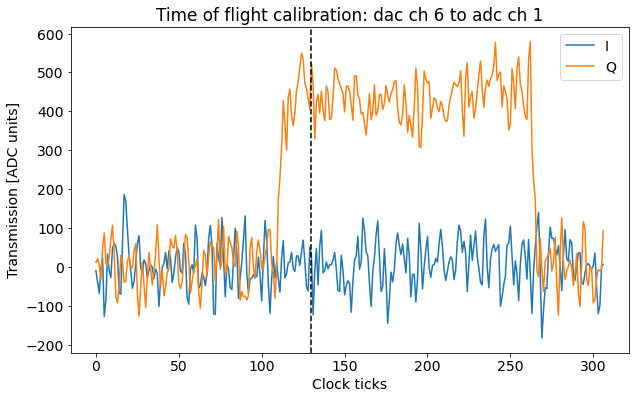

In [21]:
tof.display(adc_trig_offset=130)

# Initial single tone resonator spectroscopy

In [18]:
rspec = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
rspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 2.0 # MHz
npts = 150
rspec.cfg.expt = dict(
    start=rspec.cfg.device.readout.frequency[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=2000,
    pulse_e=False, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)
# rspec.cfg.device.readout.gain = 0.850
rspec.cfg.device.readout.relax_delay = 5 # Wait time between experiments [us]

import Pyro4.util
try:
    rspec.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/150 [00:00<?, ?it/s]

[-813.5946666666666, 5000, 1000, 0, 283.57460816560064, 502.4644021133692, -14.457008042731584]

Freq with minimum transmission: -813.2679999999999
Freq with maximum transmission: -813.588
From fit:
	f0: 5788.594666666667
	Qi: 5000
	Qe: 1000
	Q0: 833.3333333333333
	kappa [MHz]: 6.946313600000001
	phi [radians]: 0


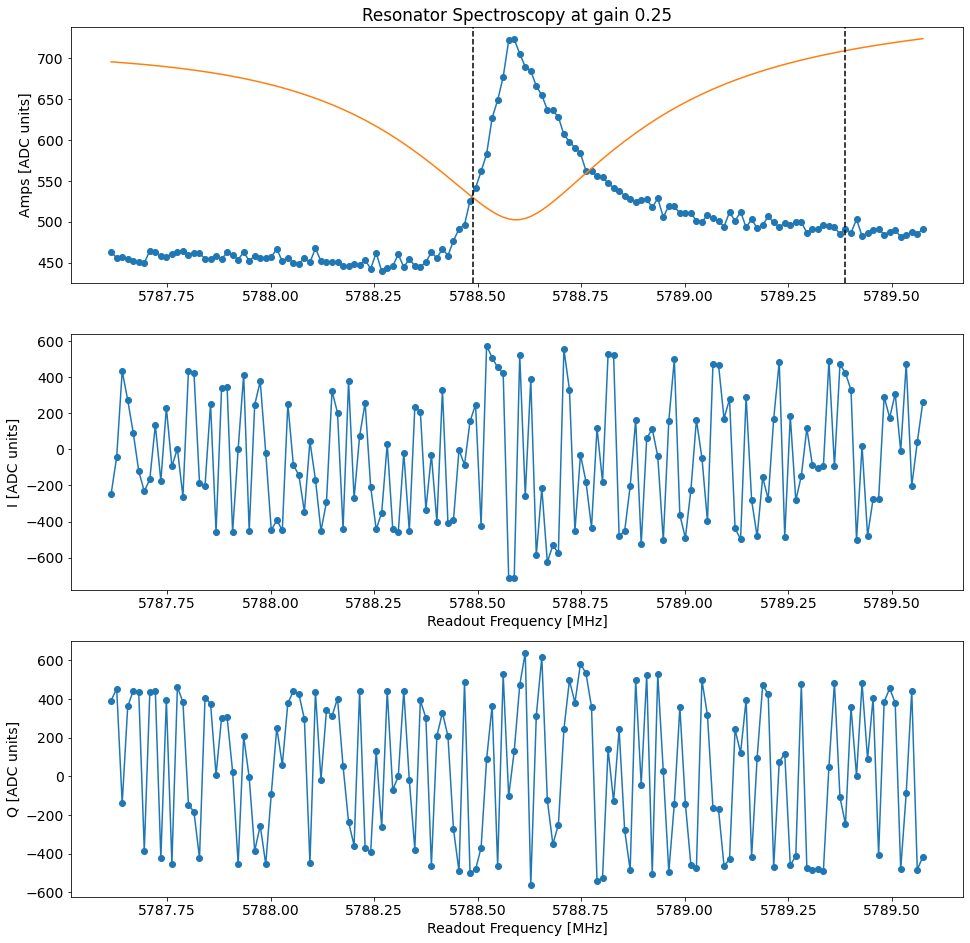

*Set cfg res 1 freq to -813.2679999999999*
*Set cfg res 1 gain to 0.25*
[{}, {'Res freq': 5788.268, 'Res kappa': 0.9763136}, {}, {}]


In [19]:
 # TESTING
# # rspec = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspec.data = temp_data

rspec.analyze(fit=True)
rspec_fit = rspec.data['fit']
# if not isinstance(rspec_fit, (list, np.ndarray)):
#     rspec.display(fit=False)
#     assert False, 'Fit failed, please manually fix!'
rspec.display(fit=True)
# yaml_cfg.device.readout.frequency[qubit_i] = rspec_fit[0]
yaml_cfg.device.readout.frequency[qubit_i] = rspec.data['xpts'][np.argmin(rspec.data['amps'])]
yaml_cfg.device.readout.gain[qubit_i] = rspec.cfg.device.readout.gain
print(f'*Set cfg res {qubit_i} freq to {yaml_cfg.device.readout.frequency[qubit_i]}*')
print(f'*Set cfg res {qubit_i} gain to {yaml_cfg.device.readout.gain[qubit_i]}*')
results_Qi.update({'Res freq':float(yaml_cfg.hw.lo.readout.frequency)*1e-6 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.device.readout.frequency[qubit_i] + yaml_cfg.hw.soc.dacs.readout.mixer_freq)})
results_Qi.update({'Res kappa':abs(rspec_fit[0]*(1/rspec_fit[1] + 1/rspec_fit[2]))})
print(all_results)

In [255]:
if save_data: saved_files.append(rspec.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00000_resonator_spectroscopy_qubit0.h5


# Qubit ge spectroscopy

## Pulse Probe (qubit) spectroscopy

In [256]:
qspec = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 150
npts = 200

qspec.cfg.expt = dict(
    start=qspec.cfg.device.qubit.f_ge[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=100, # Number of averages per point
    rounds=20, # Number of start to finish sweeps to average over
    length=1, # Qubit probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]/10), # Qubit pulse gain
    pulse_type='gauss',
    qubit=qubit_i,
)
qspec.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]
qspec.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in amps at [MHz] 139.2292563374643, HWHM -1.99617288202802
Found peak in I at [MHz] 138.93039479030287, HWHM -2.7999144370222484
Found peak in Q at [MHz] 139.41826320512945, HWHM 1.488451464028135


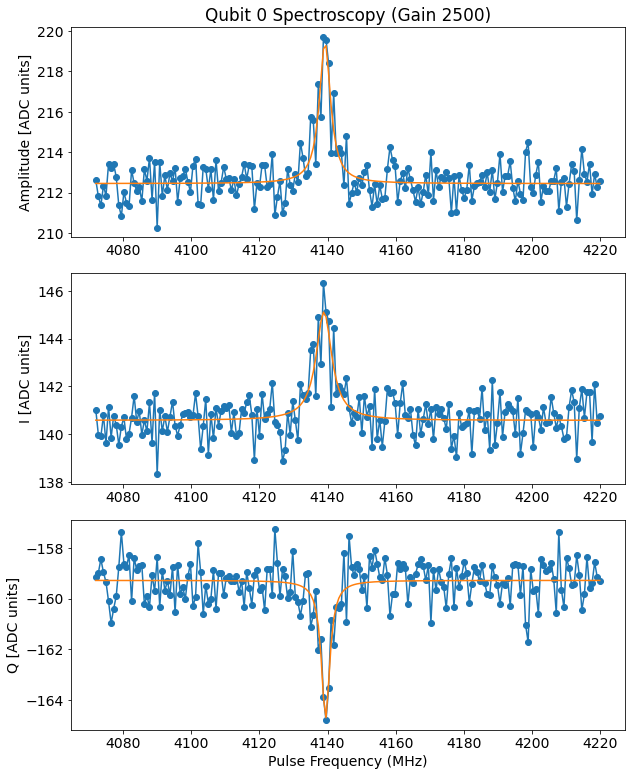

*Set qubit 0 f_ge to 139.2292563374643*
[{'Res freq': 6802.108333333334, 'Res kappa': 0.22323826365842062, 'Qubit freq': 4139.229256337464}, {'Res freq': 5788.437, 'Res kappa': 0.2, 'Qubit freq': 3463.808810074577, 'Pi pulse len': 0.018021120509126926, 'Pi pulse gain': 24842, 'T1': 96.34415654981768, 'T1 err': 6.103926194327143, 'T2R': 7.662933772194865, 'T2R err': 0.6481571517109113, 'T2E': 13.200554564826588, 'T2E err': 0.8710411220541616, 'Qubit EF freq': 3363.373743527249, 'EF pi pulse len': 0.015035725306333823, 'EF pi pulse gain': 22558}, {'Res freq': 7694.5380000000005, 'Res kappa': 0.2, 'Qubit freq': 4801.656069868829, 'Pi pulse len': 0.04668832090460338, 'Pi pulse gain': 20682, 'T1': 36.72837855356126, 'T1 err': 2.1069508140825683, 'T2R': 11.385927324230334, 'T2R err': 0.8941812837179525, 'T2E': 29.328546364159443, 'T2E err': 3.1341836088394137, 'Qubit EF freq': 4621.946057330276, 'EF pi pulse len': 0.0184315869569845, 'EF pi pulse gain': 21770}, {'Res freq': 6961.689333333334

In [257]:
# # TESTING
# # qspec = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_qubit_spectroscopy_qubit0.h5')
# qspec.data = temp_data

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qspec.analyze(fit=True, signs=[1, sign, sign])
        fit_err_i = qspec.data['fit_err_avgi'][2][2]
        fit_err_q = qspec.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[1] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[2] = sign
            best_fit_err_q = fit_err_q
    except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qspec.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qspec.analyze(fit=True, signs=best_signs)
qspec.display(fit=True, signs=best_signs)

qspec_fit, qspec_fit_err = meas.fitting.get_best_fit(qspec.data)
yaml_cfg.device.qubit.f_ge[qubit_i] = qspec_fit[2]
print(f'*Set qubit {qubit_i} f_ge to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')

results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [258]:
if save_data: saved_files.append(qspec.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00000_qubit_spectroscopy_qubit0.h5


## Pulse Probe (qubit) spectroscopy round 2

In [81]:
qspec2 = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qspec2.cfg = AttrDict(deepcopy(yaml_cfg))

span = 30
npts = 150

qspec2.cfg.expt = dict(
    start=qspec2.cfg.device.qubit.f_ge[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=100, # Number of averages per point
    rounds=20, # Number of start to finish sweeps to average over
    length=1, # Qubit probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]/20), # Qubit pulse gain
    pulse_type='gauss',
    qubit=qubit_i,
)
qspec2.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]
qspec2.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3464.046466353706, HWHM 3.204016425573646
Found peak in I at [MHz] 3464.1409503039117, HWHM 3.1449702971300613
Found peak in Q at [MHz] 3464.0322798206657, HWHM 3.2149474332371692


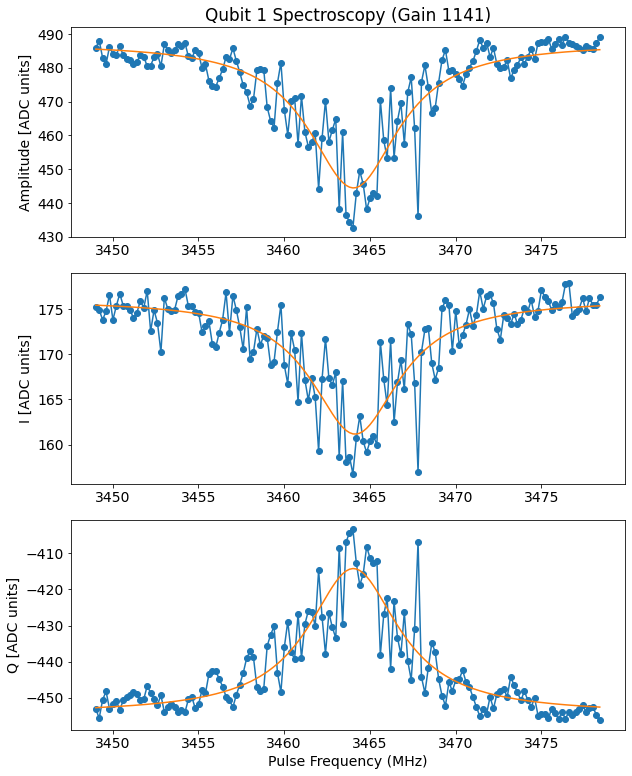

*Set qubit 1 f_ge to 3464.1409503039117*
[{'Qubit freq': 4140.590444809635, 'Pi pulse len': 0.025783836935262622, 'Pi pulse gain': 23010, 'T2R': 2.5813173212895553, 'T2R err': 0.2533851585880959, 'Qubit EF freq': 3914.7570214638718, 'EF pi pulse len': 0.02353918994670089, 'EF pi pulse gain': 24185}, {'Qubit freq': 3464.1409503039117, 'Pi pulse len': 0.015, 'Pi pulse gain': 22828, 'T1': 65.9161800295425, 'T1 err': 1.974468856418809, 'Qubit EF freq': 3363.3166988987005}, {'Qubit freq': 4799.867561236871, 'Pi pulse len': 0.02292117671644839, 'Pi pulse gain': 22631, 'T1': 50.48371244718882, 'T1 err': 0.7769652224191003}, {'Qubit freq': 4414.530389811508, 'Res freq': 6963.406, 'Res kappa': 0.1387014297651426, 'Pi pulse len': 0.015061753798497491, 'Pi pulse gain': 25187, 'T1': 148.45217294932755, 'T1 err': 11.725202434070766}]


In [82]:
# # TESTING
# # qspec2 = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_qubit_spectroscopy_qubit0.h5')
# qspec2.data = temp_data

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qspec2.analyze(fit=True, signs=[1, sign, sign])
        fit_err_amps = qspec2.data['fit_err_amps'][2][2]
        fit_err_i = qspec2.data['fit_err_avgi'][2][2]
        fit_err_q = qspec2.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[1] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[2] = sign
            best_fit_err_q = fit_err_q
    except: continue
if fit_err_amps == np.inf and best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qspec2.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qspec2.analyze(fit=True, signs=best_signs)
qspec2.display(fit=True, signs=best_signs)

qspec2_fit, qspec2_fit_err = meas.fitting.get_best_fit(qspec2.data)
yaml_cfg.device.qubit.f_ge[qubit_i] = qspec2_fit[2]
qubit_hwhm = qspec2_fit[3]
print(f'*Set qubit {qubit_i} f_ge to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')

results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [261]:
if save_data: saved_files.append(qspec2.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00001_qubit_spectroscopy_qubit0.h5


## Length Rabi

In [13]:
lengthrabi = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_qubit{qubit_i}",
    config_file=config_path,
)
lengthrabi.cfg = AttrDict(deepcopy(yaml_cfg))

lengthrabi.cfg.expt = dict(
    start=0, # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0.001,
    expts=121,
    reps=3000,
    gain=20000, # qubit gain [DAC units],
    pulse_type='gauss',
    checkZZ=False,
    checkEF=False, 
    qubits=[qubit_i],
)
# lengthrabi.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

import Pyro4.util
try:
    lengthrabi.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/121 [00:00<?, ?it/s]

Decay from avgi [us] 0.8028127643547666
Pi length from avgi data [us]: 0.02084988903868309
	Pi/2 length from avgi data [us]: 0.010424944519341546

Decay from avgq [us] 0.6262535314823134
Pi length from avgq data [us]: 0.020242788212678553
Pi/2 length from avgq data [us]: 0.010121394106339276


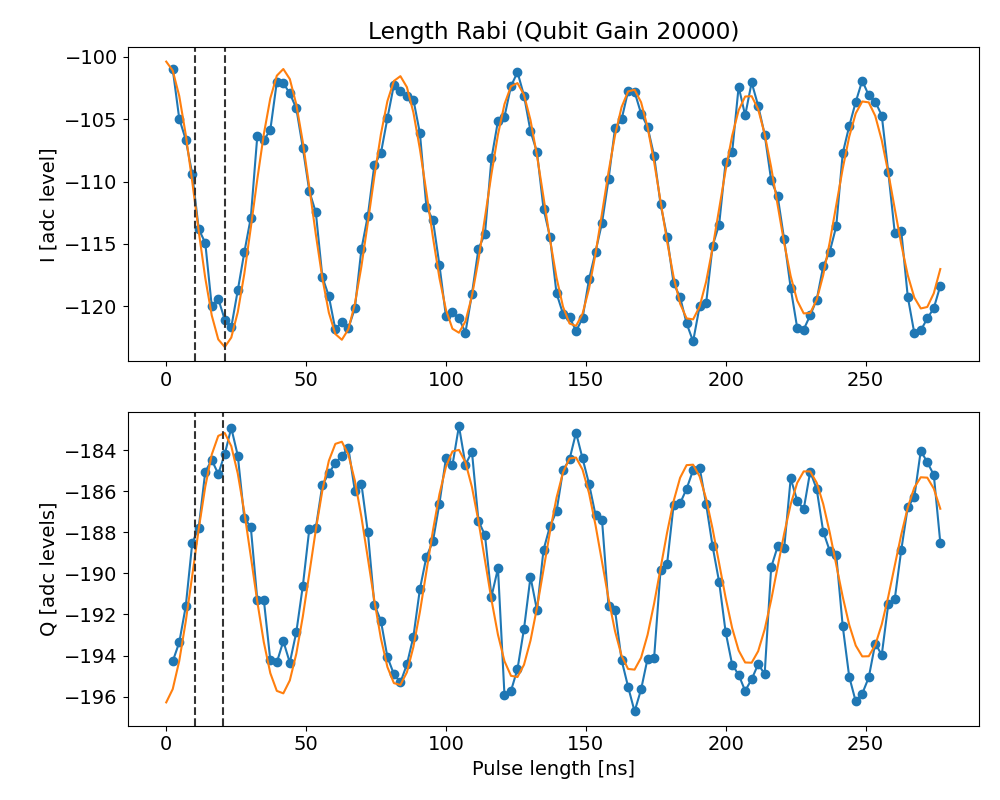

Will use sigma 0.07042806287299651 for amplitude rabi


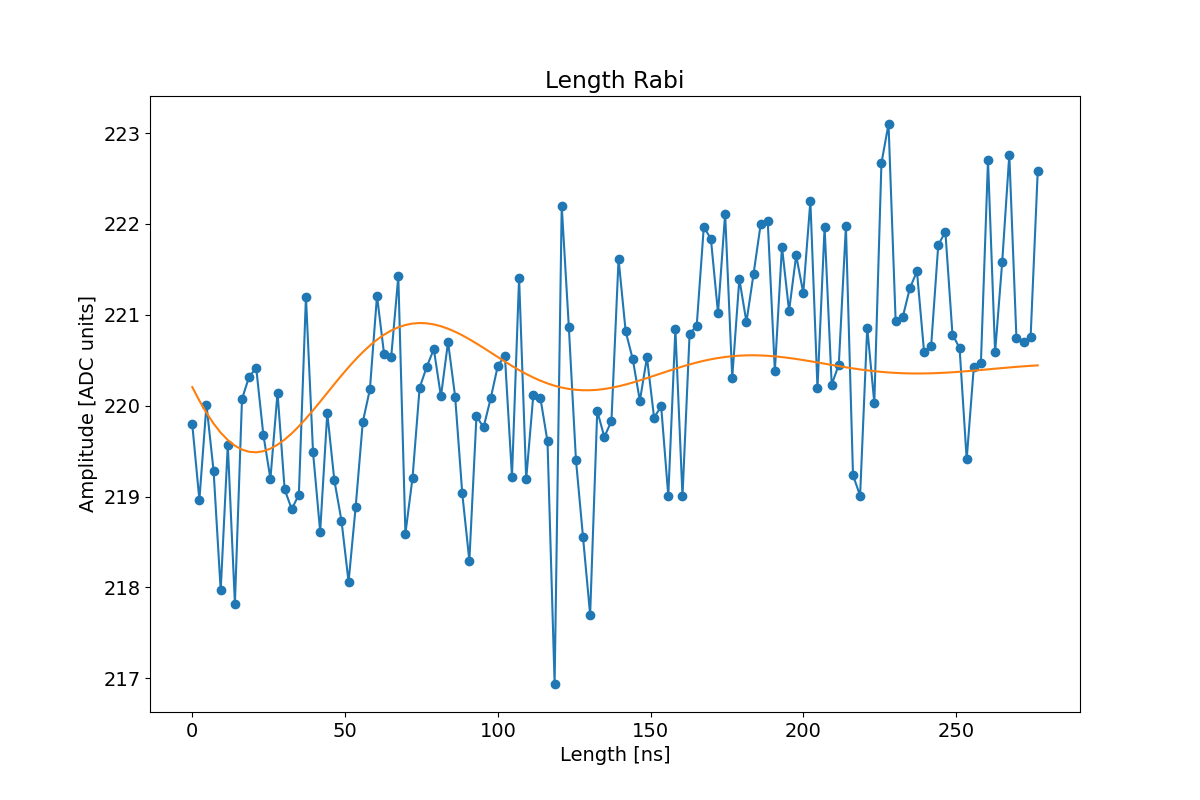

In [14]:
# # TESTING
# # lengthrabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# lengthrabi.data = temp_data

lengthrabi.analyze(fit=True)

lengthrabi_fit, lengthrabi_fit_err = meas.fitting.get_best_fit(lengthrabi.data) #, fitfunc=fitter.decaysin)

lengthrabi.display(fit=True)
p = lengthrabi_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_len = (1/2 - p[2]/180)/2/p[1]
else: pi_len = (3/2 - p[2]/180)/2/p[1]
pi_len = np.max((0.9*pi_len, 0.015)) # since we run the length rabi at a < max gain

lengthrabi_decay = p[3]

print(f'Will use sigma {pi_len} for amplitude rabi')

In [264]:
if save_data: saved_files.append(lengthrabi.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00000_length_rabi_qubit0.h5


## Amplitude Rabi

In [15]:
amprabi = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)
amprabi.cfg = AttrDict(deepcopy(yaml_cfg))

span = 32000
npts = 151
    
amprabi.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=100,
    # reps=5,
    rounds=20,
    sigma_test=pi_len, # gaussian sigma for pulse length - overrides config [us]
    pulse_type='gauss',
    checkZZ=False,
    checkEF=False, 
    qubits=[qubit_i],
)
amprabi.go(analyze=False, display=False, progress=True, save=False)

1978486461


  0%|          | 0/20 [00:00<?, ?it/s]

5275
Attempted to init fitparam 4 to -699.3329373580046, which is out of bounds 377.5692440016268 to 390.7740122000813. Instead init to 384.17162810085404
Attempted to init fitparam 4 to 384.17162810085404, which is out of bounds 784.625543514815 to 811.0011676356966. Instead init to 797.8133555752559
Pi gain from avgi data [dac units]: 5854
	Pi/2 gain from avgi data [dac units]: 2927
Pi gain from avgq data [dac units]: 7097
	Pi/2 gain from avgq data [dac units]: 3548


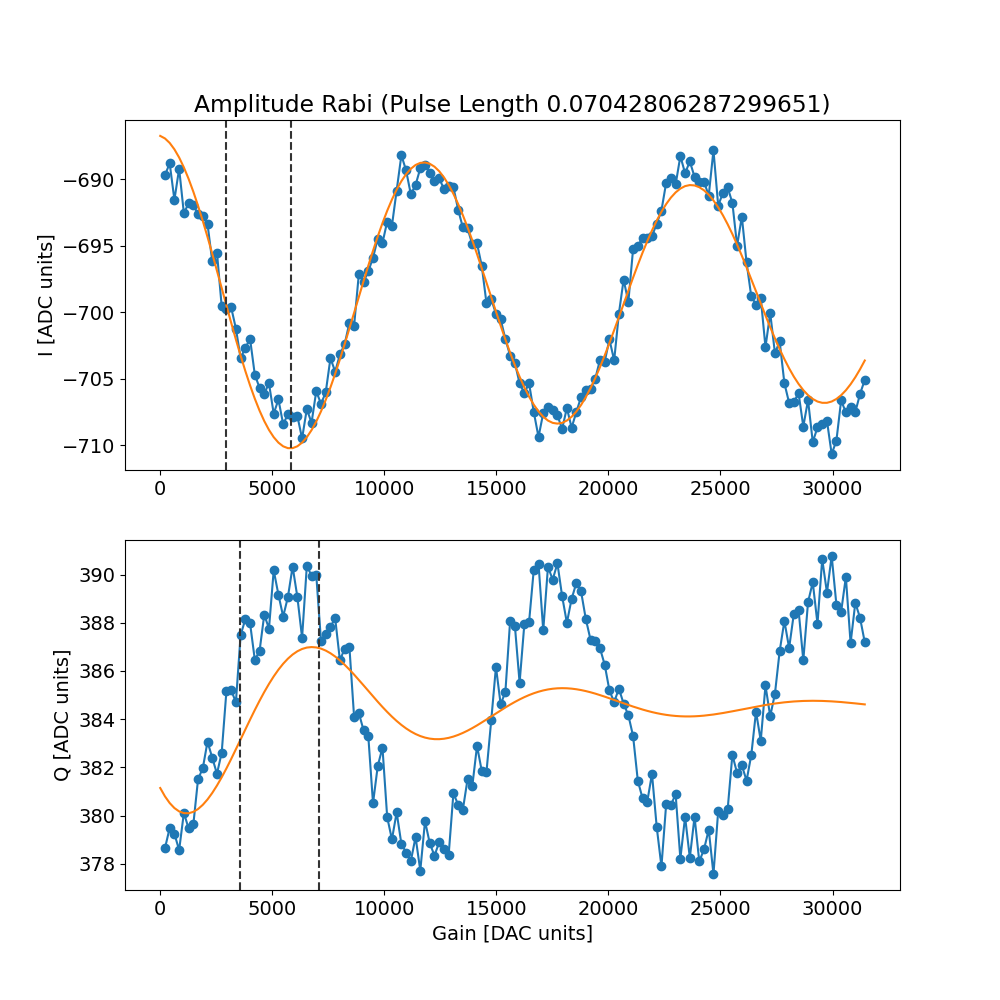

*Set pi pulse sigma for qubit 3 to 0.07042806287299651*
*Set pi pulse gain for qubit 3 to 5854*
[{}, {}, {}, {'Pi pulse len': 0.07042806287299651, 'Pi pulse gain': 5854}]


In [16]:
# # TESTING
# # amprabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# amprabi.data = temp_data

amprabi.analyze(fit=True)

amprabi_fit, amprabi_fit_err = meas.fitting.get_best_fit(amprabi.data)

p = amprabi_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabi.display(fit=False)
    print('WARNING: Fit pi pulse gain is long, please double check!')
    pi_gain = 30000
else: amprabi.display(fit=True)
yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i] = amprabi.cfg.expt.sigma_test

print(f'*Set pi pulse sigma for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i]}*')
yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(pi_gain)
print(f'*Set pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]}*')
results_Qi.update({'Pi pulse len':yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i]})
results_Qi.update({'Pi pulse gain':yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]})
print(all_results)

In [267]:
if save_data: saved_files.append(amprabi.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00000_amp_rabi_qubit0.h5


## $T_1$

In [31]:
# if lengthrabi_decay < 10: short_T1 = True
# else: short_T1 = False
short_T1 = False

In [64]:
t1 = meas.T1Experiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"t1_qubit{qubit_i}",
    config_file=config_path,
)
t1.cfg = AttrDict(deepcopy(yaml_cfg))

span = 50 if short_T1 else 300
npts = 151

t1.cfg.expt = dict(
    start=0, # wait time [us]
    step=span/npts,
    expts=npts,
    reps=100,
    # reps=5,
    rounds=30,
    qubit=qubit_i,
)
t1.cfg.device.readout.relax_delay = span # Wait time between experiments [us]
t1.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Fit T1 avgi [us]: 148.45217294932755
Fit T1 avgq [us]: 131.50900088264314


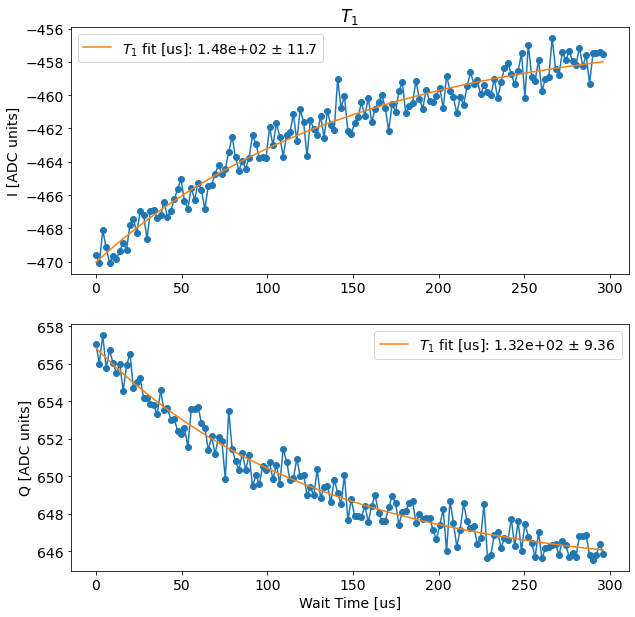

*Set qubit 3 T1 to 148.0*
*Set readout 3 relax delay to 445.0*
[{'Qubit freq': 4140.590444809635, 'Pi pulse len': 0.025783836935262622, 'Pi pulse gain': 23010, 'T2R': 2.5813173212895553, 'T2R err': 0.2533851585880959}, {'Qubit freq': 3464.960232058259, 'Pi pulse len': 0.015, 'Pi pulse gain': 22828, 'T1': 65.9161800295425, 'T1 err': 1.974468856418809}, {'Qubit freq': 4799.867561236871, 'Pi pulse len': 0.02292117671644839, 'Pi pulse gain': 22631, 'T1': 50.48371244718882, 'T1 err': 0.7769652224191003}, {'Qubit freq': 4414.530389811508, 'Res freq': 6963.406, 'Res kappa': 0.1387014297651426, 'Pi pulse len': 0.015061753798497491, 'Pi pulse gain': 25187, 'T1': 148.45217294932755, 'T1 err': 11.725202434070766}]


In [65]:
# # TESTING
# # t1 = meas.T1Experiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_t1_qubit1.h5')
# t1.data = temp_data

t1.analyze(fit=True)

t1_fit, t1_fit_err = meas.fitting.get_best_fit(t1.data) #, fitter.expfunc)

t1.display(fit=True)
yaml_cfg.device.qubit.T1[qubit_i] = np.round(t1_fit[3])
yaml_cfg.device.readout.relax_delay[qubit_i] = np.round(3*t1_fit[3])
print(f'*Set qubit {qubit_i} T1 to {yaml_cfg.device.qubit.T1[qubit_i]}*')
print(f'*Set readout {qubit_i} relax delay to {yaml_cfg.device.readout.relax_delay[qubit_i]}*')
results_Qi.update({'T1':t1_fit[3], 'T1 err':np.sqrt(t1_fit_err[3][3])})
print(all_results)

In [271]:
if save_data: saved_files.append(t1.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00000_t1_qubit0.h5


## $T_2$ Ramsey round 1

In [48]:
# yaml_cfg.device.qubit.f_ge[qubit_i] = 145.572034953271
# qubit_hwhm = 2
# short_T1 = False
short_T1 = yaml_cfg.device.qubit.T1[qubit_i] < 20
print('Short T1', short_T1)

Short T1 False


In [66]:
ramsey_freq = max(min(np.abs(np.ceil(qubit_hwhm)), 3), 2)
# ramsey_freq = 1
print(f'Ramsey freq [MHz]: {ramsey_freq}')

t2r = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)
t2r.cfg = AttrDict(deepcopy(yaml_cfg))

# make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
t2r.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(1) if short_T1 else soc.cycles2us(20), # [us] 
    # step=soc.cycles2us(2) if short_T1 else soc.cycles2us(10), # [us] 
    expts=151,
    ramsey_freq=ramsey_freq, # [MHz]
    reps=100,
    # reps=5,
    rounds=20,
    qubits=[qubit_i],
    checkZZ=False,
    checkEF=False,
)

import Pyro4.util
try:
    t2r.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

Ramsey freq [MHz]: 3


  0%|          | 0/20 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 2.29376, which is out of bounds 0.01443221476510067 to 2.1648322147651005. Instead init to 1.0896322147651005
Current pi pulse frequency: 4414.530389811508
Fit frequency from I [MHz]: 1.018446476086087 +/- 0.20679874394746817
Suggested new pi pulse frequency from fit I [MHz]:
 	4416.511943335422
 	4410.511943335422
T2 Ramsey from fit I [us]: 2.078683035714945
Fit frequency from Q [MHz]: 2.1648322147651 +/- 0.006387847317872505
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4415.365557596743
 	4409.365557596743
T2 Ramsey from fit Q [us]: 10.3779503908504


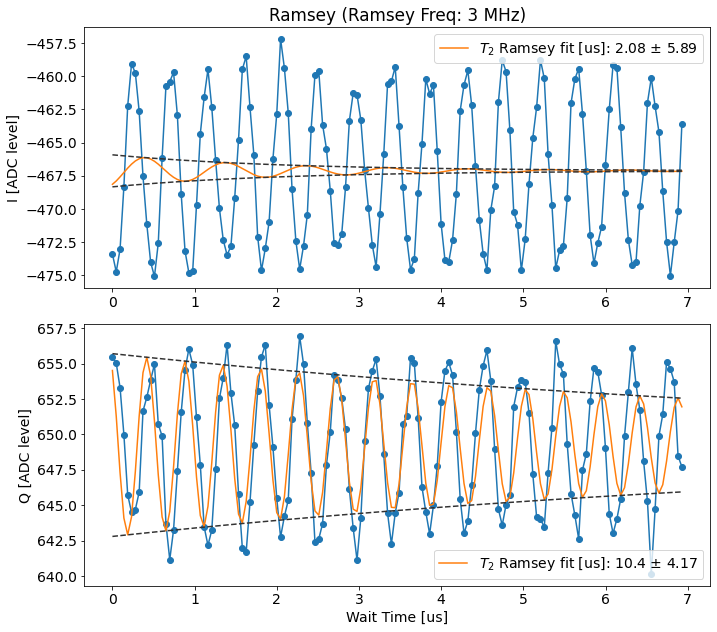

*Set qubit 3 freq to 4415.365557596743*
Alt qubit freq is 4409.365557596743


In [67]:
# # TESTING
# # t2r = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2r.data = temp_data

t2r.analyze(fit=True)

t2r_fit, t2r_fit_err, t2r_adjust = meas.fitting.get_best_fit(t2r.data, get_best_data_params=['f_adjust_ramsey'])

old_qubit_freq = t2r.cfg.device.qubit.f_ge[qubit_i]
t2r.display(fit=True)
yaml_cfg.device.qubit.f_ge[qubit_i] = old_qubit_freq + t2r_adjust[0]
alt_qubit_freq = old_qubit_freq + t2r_adjust[1]
print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
print(f'Alt qubit freq is {alt_qubit_freq}')

In [275]:
if save_data: saved_files.append(t2r.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00000_ramsey_qubit0.h5


## $T_2$ Ramsey round 2

Check that frequency adjustment helps.

In [51]:
t2r_2 = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)
t2r_2.cfg = AttrDict(deepcopy(yaml_cfg))

# make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
t2r_2.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(2) if t2r_fit[3] < 3 else soc.cycles2us(60), # [us]
    expts=151,
    ramsey_freq=ramsey_freq/10, # [MHz]
    reps=100,
    # reps=10,
    rounds=30,
    checkZZ=False,
    checkEF=False,
    qubits=[qubit_i],
)
t2r_2.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

KeyboardInterrupt: 

Current pi pulse frequency: 4141.72456445632
Fit frequency from I [MHz]: 1.4349937192357745 +/- 0.009822724834248626
Suggested new pi pulse frequency from fit I [MHz]:
 	4140.589570737085
 	4139.989570737084
T2 Ramsey from fit I [us]: 2.482608439448972
Fit frequency from Q [MHz]: 1.4273122996316554 +/- 0.009749900259557027
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4140.597252156688
 	4139.997252156688
T2 Ramsey from fit Q [us]: 2.5270463686523863


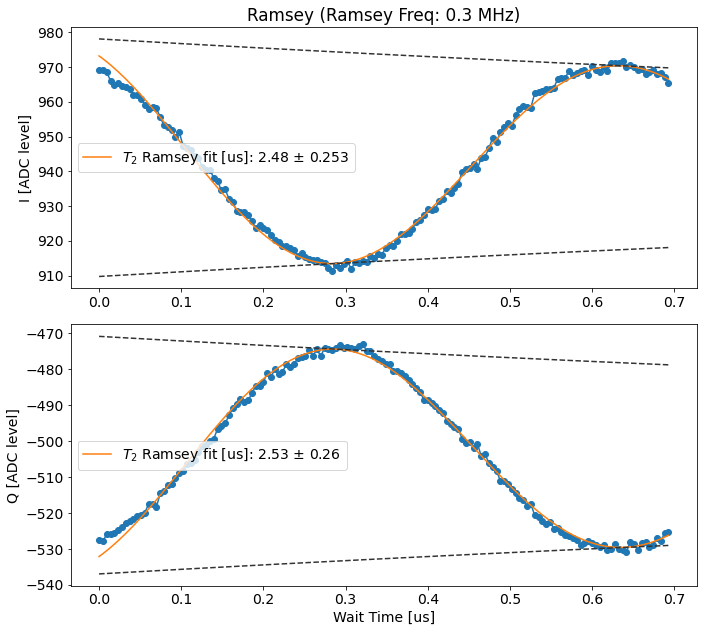

*Set qubit 0 freq to 4140.590444809635*
[{'Qubit freq': 4140.590444809635, 'Pi pulse len': 0.025783836935262622, 'Pi pulse gain': 23010, 'T2R': 2.5813173212895553, 'T2R err': 0.2533851585880959}, {}, {}, {}]
Redo T2R: False


In [ ]:
# # TESTING
# # t2r_2 = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2r_2.data = temp_data

redo_t2r = True

t2r_2.analyze(fit=True)

t2r_2_fit, t2r_2_fit_err, t2r_2_adjust = meas.fitting.get_best_fit(t2r_2.data, get_best_data_params=['f_adjust_ramsey'])

t2r_2.display(fit=True)
final_qubit_freq = t2r_2.cfg.device.qubit.f_ge[qubit_i] + t2r_2_adjust[0]
if abs(t2r_2_adjust[0]) <= abs(t2r_adjust[0]):
    redo_t2r = False
    yaml_cfg.device.qubit.f_ge[qubit_i] = final_qubit_freq
    print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
    results_Qi.update({'T2R':t2r_2_fit[3], 'T2R err':np.sqrt(t2r_2_fit_err[3][3])})
    results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
    print(all_results)
else: # redo_t2r = True
    yaml_cfg.device.qubit.f_ge[qubit_i] = alt_qubit_freq 
    print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
print(f'Redo T2R: {redo_t2r}')

In [278]:
if save_data: saved_files.append(t2r_2.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00001_ramsey_qubit0.h5


## $T_2$ Ramsey round 3

Run again in case adjust frequency in the wrong direction previously.

In [ ]:
if redo_t2r:
    t2r_3 = meas.RamseyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"ramsey_qubit{qubit_i}",
        config_file=config_path,
    )
    t2r_3.cfg = AttrDict(deepcopy(yaml_cfg))

    # make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    t2r_3.cfg.expt = dict(
        start=0, # wait time tau [us]
        step=soc.cycles2us(2) if short_T1 else soc.cycles2us(10), # [us]
        expts=151,
        ramsey_freq=ramsey_freq/2, # [MHz]
        reps=100,
        # reps=10,
        rounds=30,
        checkZZ=False,
        checkEF=False,
        qubit=[qubit_i],
    )
    t2r_3.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
if redo_t2r:
    # # TESTING
    # # t2r_3 = meas.RamseyExperiment(config_file=config_path)
    # temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
    # t2r_3.data = temp_data

    t2r_3.analyze(fit=True)

    t2r_3_fit, t2r_3_fit_err, t2r_3_adjust = meas.fitting.get_best_fit(t2r_3.data, compare_param_i=3, get_best_data_params=['f_ge_adjust_ramsey'])

    if not isinstance(t2r_3_fit, (list, np.ndarray)):
        t2r_3.display(fit=True)
        final_qubit_freq = t2r_3.cfg.device.qubit.f_ge + t2r_3_adjust[0]
        if abs(t2r_3_adjust[0]) <= abs(t2r_adjust[0]):
            yaml_cfg.device.qubit.f_ge[qubit_i] = final_qubit_freq
            print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
            i_best = np.argmin([t2r_fit_err[3][3], t2r_3_fit_err[3][3]])
            results_Qi.update({'T2':[t2r_fit[3], t2r_3_fit[3]][i_best], 'T2 err':np.sqrt([t2r_fit_err[3][3], t2r_3_fit_err[3][3]][i_best])})
            results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
            print(all_results)
        else:
            assert False, 'Something is wrong, please manually fix!'
    else:
        t2r_3.display(fit=False)
        assert False, 'Fit failed, please manually fix!'

In [281]:
if redo_t2r:
    if save_data: saved_files.append(t2r_3.save_data())

## $T_2$ Echo

In [39]:
t2e = meas.RamseyEchoExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"echo_qubit{qubit_i}",
    config_file=config_path,
)
t2e.cfg = AttrDict(deepcopy(yaml_cfg))

t2e.cfg.expt = dict(
    start=0, # total wait time b/w the two pi/2 pulses [us]
    step=soc.cycles2us(80), # make sure nyquist freq = 0.5*(1/step) > ramsey (signal) freq!
    expts=151,
    ramsey_freq=max(ramsey_freq/10, 0.100), # frequency by which to advance phase [MHz]
    num_pi=1, # number of pi pulses
    cpmg=True, # set either cp or cpmg to True
    cp=False, # set either cp or cpmg to True
    reps=100,
    # reps=10,
    rounds=30,
    qubit=qubit_i,
)
t2e.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Current qubit frequency: 3464.332338581064
Fit frequency from I [MHz]: 0.1995403221580302 +/- 0.00040514778864366477
T2 Echo from fit I [us]: 33.76927546211512
Fit frequency from Q [MHz]: 0.2000581377317768 +/- 0.00011950781195763397
T2 Echo from fit Q [us]: 39.62368419487856


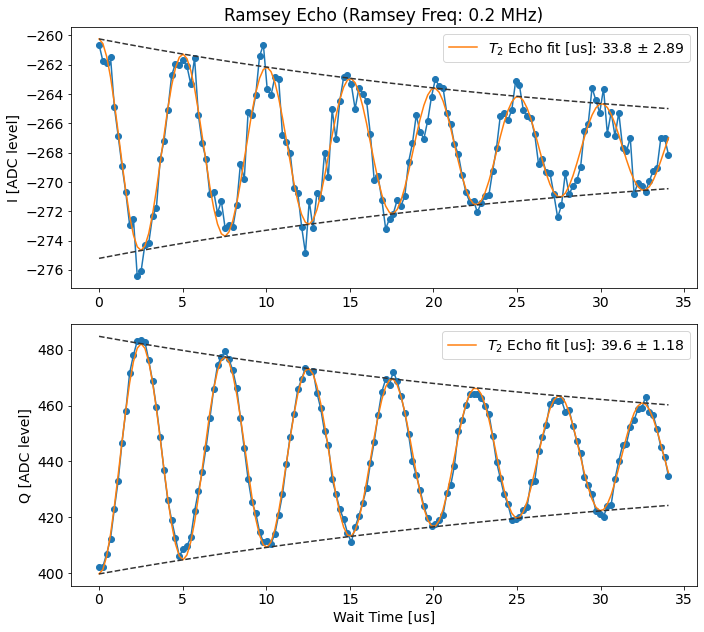

[{}, {'Qubit freq': 3464.332338581064, 'Pi pulse len': 0.018252858854027533, 'Pi pulse gain': 23117, 'T1': 87.89641841075972, 'T1 err': 1.5550234959313187, 'T2E': 33.76927546211512, 'T2E err': 2.8890119779752013}, {}, {}]


In [40]:
# # TESTING
# # t2e = meas.RamseyEchoExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_echo_qubit1.h5')
# t2e.data = temp_data

t2e.analyze(fit=True)

t2e_fit, t2e_fit_err = meas.fitting.get_best_fit(t2e.data)

if not isinstance(t2e_fit, (list, np.ndarray)):
    t2e.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

t2e.display(fit=True)
results_Qi.update({'T2E':t2e_fit[3], 'T2E err':np.sqrt(t2e_fit_err[3][3])})
print(all_results)
# print('Results updated.')

In [284]:
if save_data: saved_files.append(t2e.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00000_echo_qubit0.h5


# Resonator chi shift (g/e)

In [120]:
rspec_chi = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_chi_qubit{qubit_i}",
    config_file=config_path,
)
rspec_chi.cfg = AttrDict(deepcopy(yaml_cfg))

span = 5 # MHz
npts = 151
rspec_chi.cfg.expt = dict(
    start=rspec_chi.cfg.device.readout.frequency[qubit_i]-span/2, # MHz
    # start=rspec_chi.cfg.device.readout.frequency[qubit_i]-rspec_chi.cfg.device.readout.lo_sideband[qubit_i]*span, # MHz
    step=span/npts,
    expts=npts,
    reps=3000,
    pulse_e=True, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)
# rspec_chi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]
rspec_chi.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/151 [00:00<?, ?it/s]

[-808.3161720994943, 5000, 1000, 0, 31.972478802377907, 338.4097714428876]

Freq with minimum transmission: -807.7532581922094
Freq with maximum transmission: -805.9320661392293
From fit:
	f0: -808.3161720994943
	Qi: 5000
	Qe: 1000
	Q0: 833.3333333333333
	kappa [MHz]: -0.9699794065193933
	phi [radians]: 0


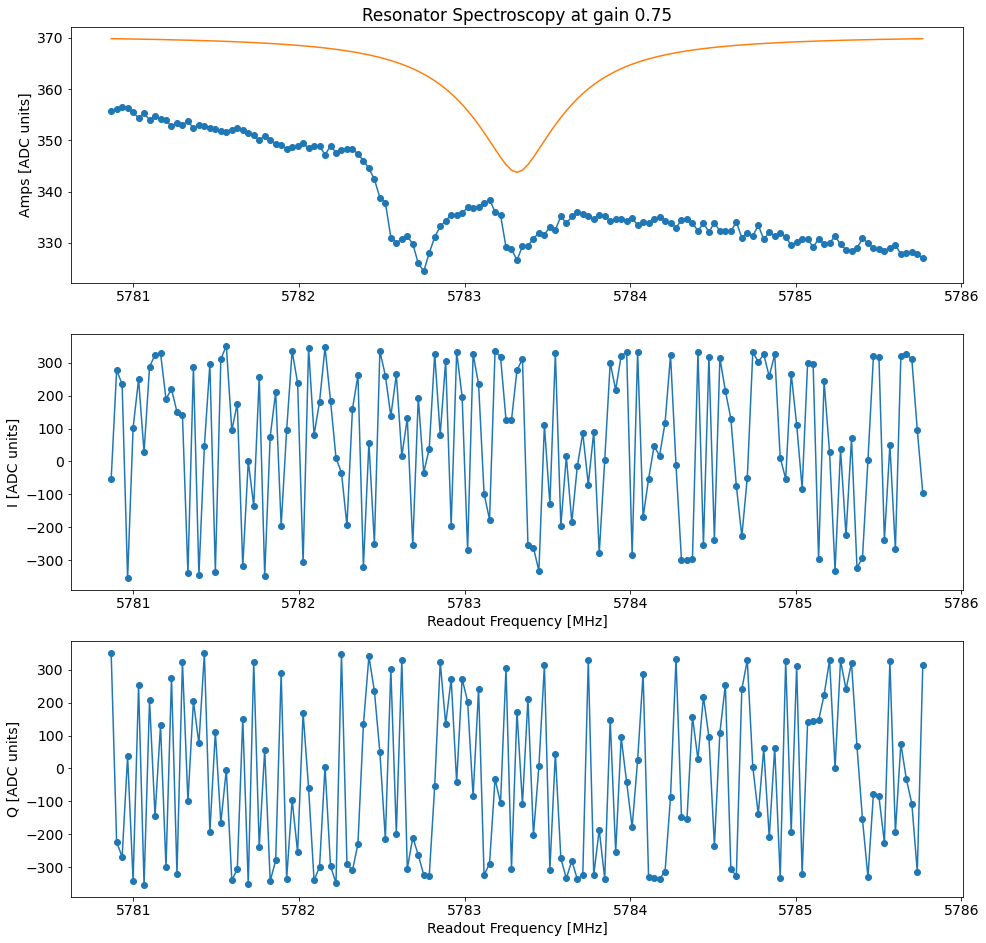

[{'Res freq': 7688.874258045896, 'Res kappa': 0.9756441096550745, 'Qubit freq': 4823.861508259508, 'Pi pulse len': 0.03956011335259716, 'Pi pulse gain': 22779, 'T1': 97.14424019836063, 'T1 err': 4.6355555889821245, 'T2R': 8.312336278065233, 'T2R err': 0.3957274632565941, 'T2E': 17.688832442781287, 'T2E err': 0.7326171278801736, 'Qubit EF freq': 4640.557961214359, 'EF pi pulse len': 0.025, 'EF pi pulse gain': 16093}, {'Res freq': 5783.299615808103, 'Res kappa': 0.30608491399697296, 'Qubit freq': 3472.403818423059, 'Pi pulse len': 0.020738980081829388, 'Pi pulse gain': 23185, 'T1': 52.567929832315315, 'T1 err': 0.6768379550408044, 'T2R': 1.8746149564710788, 'T2R err': 0.1533478261277939, 'T2E': 15.873701812556538, 'T2E err': 0.3698073838910515, 'Res chi shift (e - g)': -0.5463576158940668, 'Qubit EF freq': 603.7170605500958, 'EF pi pulse len': 0.025, 'EF pi pulse gain': 2680, 'Res chi shift (f - g)': 5.546357615894067}, {}, {}]


In [121]:
# # TESTING
# # rspec_chi = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspec_chi.data = temp_data

rspec_chi.analyze(fit=True)
rspec_chi_fit = rspec_chi.data['fit']
if not isinstance(rspec_chi_fit, (list, np.ndarray)):
    rspec_chi.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
rspec_chi.display(fit=True)
# res_freq_e = rspec_chi_fit[0]
res_freq_e = rspec_chi.data['xpts'][np.argmin(rspec_chi.data['amps'])]
# res_freq_e = -83
results_Qi.update({'Res chi shift (e - g)': yaml_cfg.device.readout.lo_sideband[qubit_i]*(res_freq_e - yaml_cfg.device.readout.frequency[qubit_i])})
# res_freq_e = 6953.5
# results_Qi.update({'Res chi shift (e - g)': res_freq_e - (5925 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.hw.soc.dacs.readout.mixer_freq + yaml_cfg.device.readout.frequency[qubit_i]))})
print(all_results)

In [ ]:
if save_data: saved_files.append(rspec_chi.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_220919\00000_resonator_spectroscopy_chi_qubit3.h5


# Qubit ef spectroscopy

## Pulse Probe ef spectroscopy

In [ ]:
qEFspec = meas.PulseProbeEFSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qEFspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 80
npts = 180

qEFspec.cfg.expt = dict(
    start=qEFspec.cfg.device.qubit.f_ef[qubit_i]-0.5*span, # resonator frequency to be mixed up [MHz]
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=30, # Number of start to finish sweeps to average over
    length=1, # ef probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]/100), # ef pulse gain
    # gain=5000,
    pulse_type='gauss',
    qubit=qubit_i,
)
qEFspec.cfg.device.readout.relax_delay = qEFspec.cfg.device.qubit.T1[qubit_i] # Wait time between experiments [us]
qEFspec.go(analyze=False, display=False, progress=True, save=False)

Found peak in amps at [MHz] 3914.805297112222, HWHM 3.032768518800382
Found peak in I at [MHz] 3914.8579103868224, HWHM 3.0336573396841375
Found peak in Q at [MHz] 3914.78013553069, HWHM 3.0374204558272657


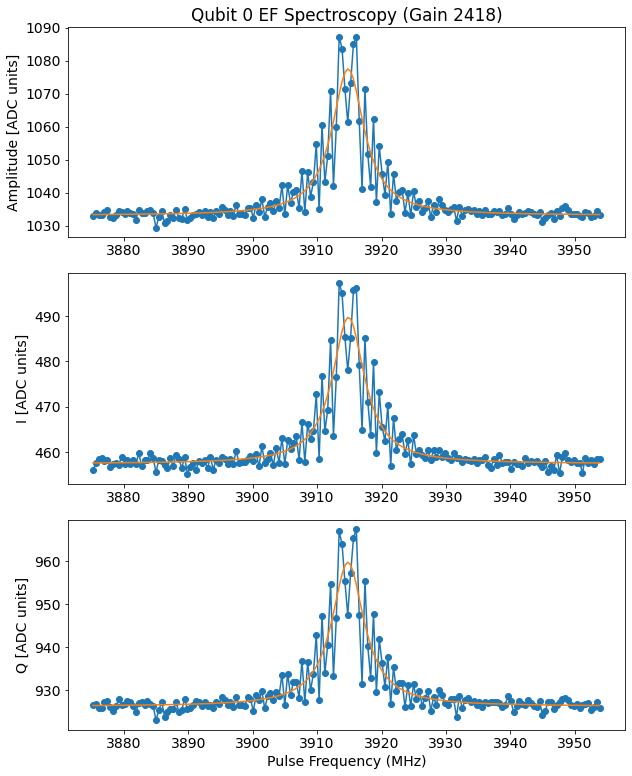

*Set qubit 0 f_ef to 3914.78013553069*
[{'Pi pulse len': 0.030994679274175756, 'Pi pulse gain': 22226, 'Qubit EF freq': 3914.78013553069}, {'Pi pulse len': 0.01781063065883571, 'Pi pulse gain': 21672, 'EF pi pulse len': 0.015, 'EF pi pulse gain': 21716}, {}, {}]


In [ ]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec.analyze(data=temp_data, fit=True)

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qEFspec.analyze(fit=True, signs=[1, sign, sign])
        fit_err_i = qEFspec.data['fit_err_avgi'][2][2]
        fit_err_q = qEFspec.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[1] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[2] = sign
            best_fit_err_q = fit_err_q
    except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qEFspec.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qEFspec.analyze(fit=True, signs=best_signs)
qEFspec.display(fit=True, signs=best_signs)

better_fit = (qEFspec.data['fit_avgi'], qEFspec.data['fit_avgq'])[np.argmin((qEFspec.data['fit_err_avgi'][2][2], qEFspec.data['fit_err_avgq'][2][2]))]
yaml_cfg.device.qubit.f_ef[qubit_i] = better_fit[2]
print(f'*Set qubit {qubit_i} f_ef to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')

results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [287]:
if save_data: saved_files.append(qEFspec.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00000_qubit_EF_spectroscopy_qubit0.h5


## Pulse Probe EF spectroscopy round 2

In [114]:
qEFspec2 = meas.PulseProbeEFSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qEFspec2.cfg = AttrDict(deepcopy(yaml_cfg))

span = 20
npts = 150

qEFspec2.cfg.expt = dict(
    start=qEFspec2.cfg.device.qubit.f_ef[qubit_i]-0.5*span, # resonator frequency to be mixed up [MHz]
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=30, # Number of start to finish sweeps to average over
    length=1, # ef probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]/150), # ef pulse gain
    pulse_type='gauss',
    qubit=qubit_i,
)
qEFspec2.cfg.device.readout.relax_delay = qEFspec2.cfg.device.qubit.T1[qubit_i] # Wait time between experiments [us]
qEFspec2.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3363.418161440717, HWHM -0.37819582134230595
Found peak in I at [MHz] 3363.3993551307403, HWHM -0.37655909333050436
Found peak in Q at [MHz] 3373.147705833963, HWHM 2.6400415466907323


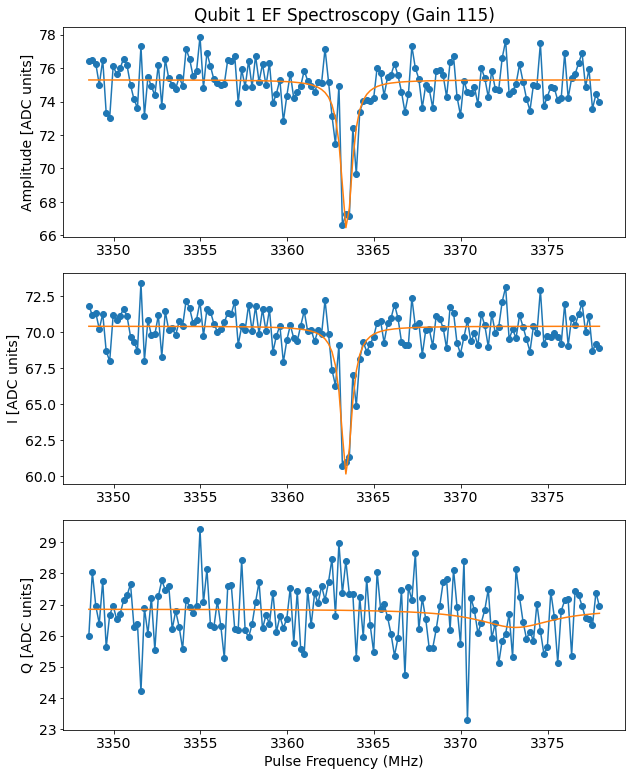

*Set qubit 1 f_ef to 3363.3993551307403*
[{'Qubit freq': 4140.590444809635, 'Pi pulse len': 0.025783836935262622, 'Pi pulse gain': 23010, 'T2R': 2.5813173212895553, 'T2R err': 0.2533851585880959, 'Qubit EF freq': 3914.7570214638718, 'EF pi pulse len': 0.02353918994670089, 'EF pi pulse gain': 24185}, {'Qubit freq': 3464.1409503039117, 'Pi pulse len': 0.015, 'Pi pulse gain': 22828, 'T1': 65.9161800295425, 'T1 err': 1.974468856418809, 'Qubit EF freq': 3363.3993551307403, 'EF pi pulse len': 0.015, 'EF pi pulse gain': 20651}, {'Qubit freq': 4799.867561236871, 'Pi pulse len': 0.02292117671644839, 'Pi pulse gain': 22631, 'T1': 50.48371244718882, 'T1 err': 0.7769652224191003}, {'Qubit freq': 4414.530389811508, 'Res freq': 6963.406, 'Res kappa': 0.1387014297651426, 'Pi pulse len': 0.015061753798497491, 'Pi pulse gain': 25187, 'T1': 148.45217294932755, 'T1 err': 11.725202434070766}]


In [115]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec2.analyze(data=temp_data, fit=True)

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    qEFspec2.analyze(fit=True, signs=[1, sign, sign])
    fit_err_i = qEFspec2.data['fit_err_avgi'][2][2]
    fit_err_q = qEFspec2.data['fit_err_avgq'][2][2]
    if fit_err_i < best_fit_err_i:
        best_signs[1] = sign
        best_fit_err_i = fit_err_i
    if fit_err_q < best_fit_err_q:
        best_signs[2] = sign
        best_fit_err_q = fit_err_q
    # except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qEFspec2.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qEFspec2.analyze(fit=True, signs=best_signs)
qEFspec2.display(fit=True, signs=best_signs)

qEFspec2_fit, qEFspec2_fit_err = meas.fitting.get_best_fit(qEFspec2.data)

yaml_cfg.device.qubit.f_ef[qubit_i] = qEFspec2_fit[2]
qubitEF_hwhm = qEFspec2_fit[3]
print(f'*Set qubit {qubit_i} f_ef to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')

results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [116]:
if save_data: saved_files.append(qEFspec2.save_data())

## Length EF Rabi

In [72]:
lengthrabiEF = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabiEF_qubit{qubit_i}",
    config_file=config_path,
)
lengthrabiEF.cfg = AttrDict(deepcopy(yaml_cfg))

lengthrabiEF.cfg.expt = dict(
    start=soc.cycles2us(3), # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0.001,
    expts=121,
    reps=3000,
    gain=20000, # qubit gain [DAC units],
    pulse_type='gauss',
    checkZZ=False,
    checkEF=True, 
    qubits=[qubit_i],
)
# lengthrabiEF.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

import Pyro4.util
try:
    lengthrabiEF.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/121 [00:00<?, ?it/s]

Decay from avgi [us] 0.0830078125
Pi length from avgi data [us]: 0.043226940410471884
	Pi/2 length from avgi data [us]: 0.021613470205235942

Decay from avgq [us] 0.8230491632020442
Pi length from avgq data [us]: 0.015802992308895272
Pi/2 length from avgq data [us]: 0.007901496154447636


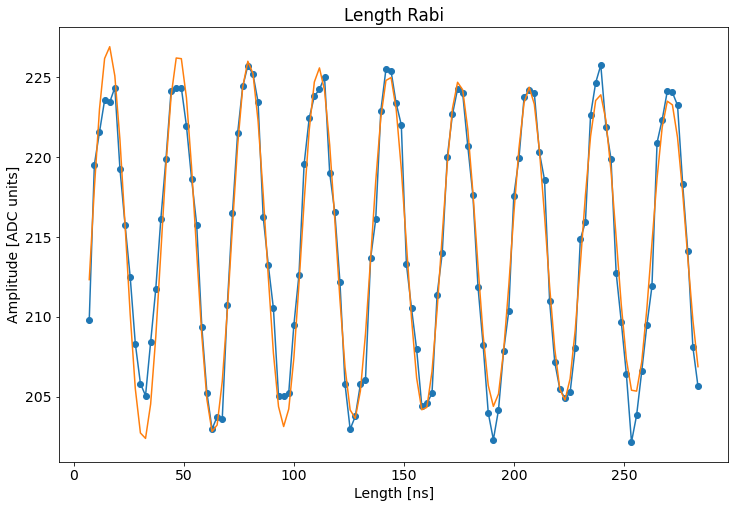

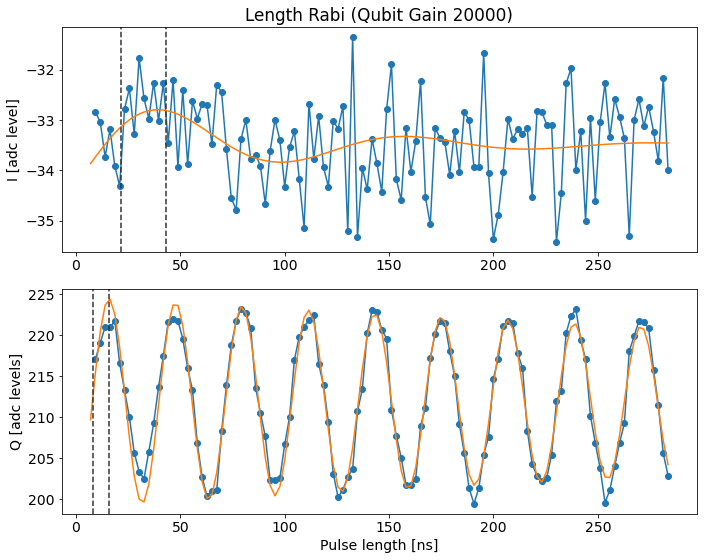

Will use sigma 0.038904246369424696 for amplitude rabi EF


In [73]:
# # TESTING
# # lengthrabiEF = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# lengthrabiEF.data = temp_data

lengthrabiEF.analyze(fit=True)

lengthrabiEF_fit, lengthrabiEF_fit_err = meas.fitting.get_best_fit(lengthrabiEF.data) #, fitfunc=fitter.decaysin)

lengthrabiEF.display(fit=True)
p = lengthrabiEF_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_lenEF = (1/2 - p[2]/180)/2/p[1]
else: pi_lenEF = (3/2 - p[2]/180)/2/p[1]
pi_lenEF = np.max((0.9*pi_lenEF, 0.015)) # since we run the length rabi at a < max gain

lengthrabiEF_decay = p[3]

print(f'Will use sigma {pi_lenEF} for amplitude rabi EF')

In [119]:
if save_data: saved_files.append(lengthrabi.save_data())

## Amplitude EF Rabi

The EF pi pulse amplitude should be stored in <code>cfg.device.qubit.pulses.pi_ef.gain</code>.

In [62]:
amprabiEF = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

amprabiEF.cfg = AttrDict(deepcopy(yaml_cfg))

span = 32000
npts = 101

amprabiEF.cfg.expt = dict(
    start=1, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=100,
    rounds=30,
    sigma_test=pi_lenEF, # gaussian sigma for pulse length - default from cfg [us]
    pulse_type='gauss',
    checkZZ=False,
    checkEF=True, 
    qubits=[qubit_i],
)

# print(amprabiEF.cfg)
amprabiEF.go(analyze=False, display=False, progress=True, save=False)

2066141808


  0%|          | 0/30 [00:00<?, ?it/s]

22120
Attempted to init fitparam 4 to 16.789372918530567, which is out of bounds 35.4388259455063 to 83.25900582892776. Instead init to 59.34891588721703
Pi gain from avgi data [dac units]: 24952
	Pi/2 gain from avgi data [dac units]: 12476
Pi gain from avgq data [dac units]: 23636
	Pi/2 gain from avgq data [dac units]: 11818


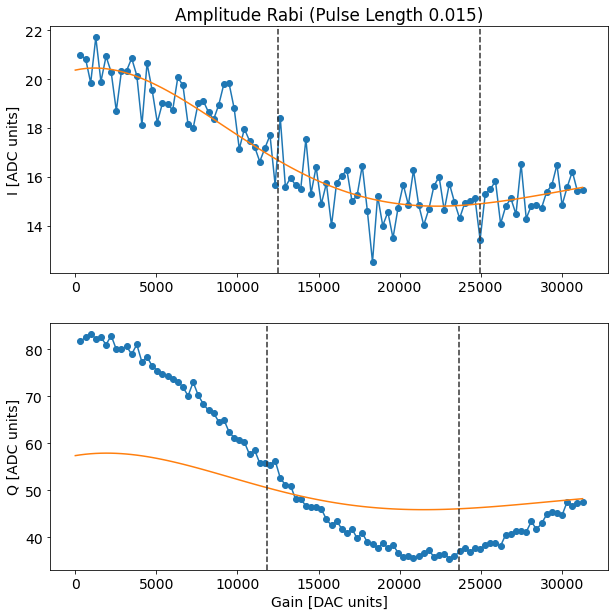

*Set EF pi pulse sigma for qubit 3 to 0.015*
*Set EF pi pulse gain for qubit 3 to 24952*
[{'Pi pulse len': 0.030994679274175756, 'Pi pulse gain': 22226, 'Qubit EF freq': 3914.78013553069, 'EF pi pulse len': 0.0286027449771282, 'EF pi pulse gain': 22869}, {'Pi pulse len': 0.01781063065883571, 'Pi pulse gain': 21672, 'EF pi pulse len': 0.015, 'EF pi pulse gain': 21716}, {'Pi pulse len': 0.01678984766016672, 'Pi pulse gain': 23287, 'EF pi pulse len': 0.015, 'EF pi pulse gain': 23173}, {'Pi pulse len': 0.01824539607464021, 'Pi pulse gain': 22760, 'EF pi pulse len': 0.015, 'EF pi pulse gain': 24952}]


In [77]:
# TESTING
# amprabiEF = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_EF_qubit1.h5')
# amprabiEF.data = temp_data

amprabiEF.analyze(fit=True)

amprabiEF_fit, amprabiEF_fit_err = meas.fitting.get_best_fit(amprabiEF.data)

p = amprabiEF_fit

if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabiEF.display(fit=False)
    print('WARNING: Fit pi pulse gain is long, please double check!')
    pi_gain = 30000
else: amprabiEF.display(fit=True)

yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i] = amprabiEF.cfg.expt.sigma_test
print(f'*Set EF pi pulse sigma for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i]}*')
yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i] = int(pi_gain)
print(f'*Set EF pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]}*')
results_Qi.update({'EF pi pulse len':yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i]})
results_Qi.update({'EF pi pulse gain':yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]})
print(all_results)

In [75]:
if save_data: saved_files.append(amprabiEF.save_data())

## EF Ramsey Fringe
Update the ef frequency in <code>cfg.qubit.f_ef</code>.

In [123]:
# yaml_cfg.device.qubit.f_ge[qubit_i] = 145.572034953271
# qubitEF_hwhm = 7
# short_T1 = False

In [105]:
ramseyEF_freq = max(min(np.abs(np.ceil(qubitEF_hwhm)), 3), 2)

t2EFr = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="ramseyEF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

t2EFr.cfg = AttrDict(deepcopy(yaml_cfg))

t2EFr.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(10), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=151,
    ramsey_freq=ramseyEF_freq, # [MHz]
    checkZZ=False,
    checkEF=True,
    reps=100,
    rounds=30,
    qubits=[qubit_i],
)

import Pyro4.util
try:
    t2EFr.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/30 [00:00<?, ?it/s]

Current pi pulse frequency: 3363.0636664277886
Fit frequency from I [MHz]: 2.663258985819021 +/- 0.005194722994271176
Suggested new pi pulse frequency from fit I [MHz]:
 	3363.4004074419695
 	3357.4004074419695
T2 Ramsey from fit I [us]: 3.3367299846401863
Fit frequency from Q [MHz]: 2.6661547065171898 +/- 0.005388114109000723
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3363.3975117212713
 	3357.3975117212713
T2 Ramsey from fit Q [us]: 3.1731533276029924


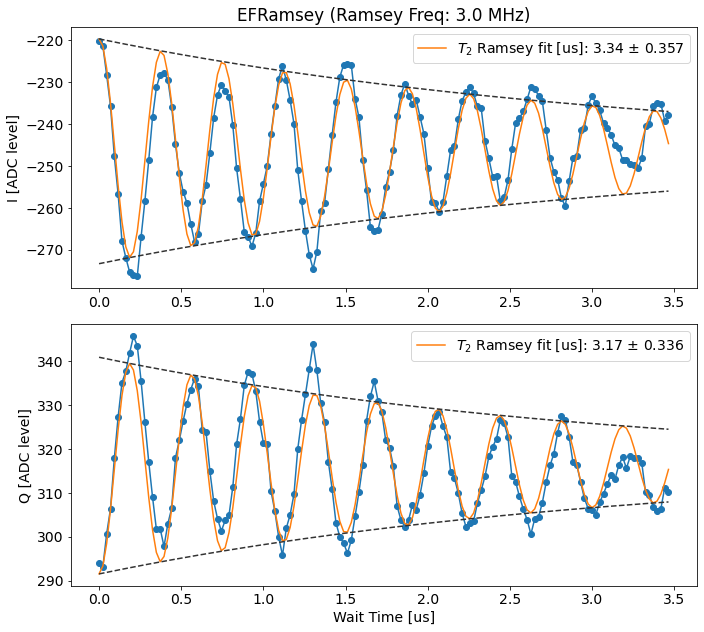

*Set qubit 1 EF freq to 3363.3975117212713*
[{'Qubit freq': 4140.590444809635, 'Pi pulse len': 0.025783836935262622, 'Pi pulse gain': 23010, 'T2R': 2.5813173212895553, 'T2R err': 0.2533851585880959, 'Qubit EF freq': 3914.7570214638718, 'EF pi pulse len': 0.02353918994670089, 'EF pi pulse gain': 24185}, {'Qubit freq': 3464.1409503039117, 'Pi pulse len': 0.015, 'Pi pulse gain': 22828, 'T1': 65.9161800295425, 'T1 err': 1.974468856418809, 'Qubit EF freq': 3363.3975117212713, 'EF pi pulse len': 0.015, 'EF pi pulse gain': 20651}, {'Qubit freq': 4799.867561236871, 'Pi pulse len': 0.02292117671644839, 'Pi pulse gain': 22631, 'T1': 50.48371244718882, 'T1 err': 0.7769652224191003}, {'Qubit freq': 4414.530389811508, 'Res freq': 6963.406, 'Res kappa': 0.1387014297651426, 'Pi pulse len': 0.015061753798497491, 'Pi pulse gain': 25187, 'T1': 148.45217294932755, 'T1 err': 11.725202434070766}]


In [106]:
# # TESTING
# # t2EFr = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2EFr.data = temp_data

t2EFr.analyze(fit=True)
t2EFr_fit, t2EFr_fit_err, t2EFr_adjust = meas.fitting.get_best_fit(t2EFr.data, get_best_data_params=['f_adjust_ramsey'])
old_qubit_freq = t2EFr.cfg.device.qubit.f_ef[qubit_i]

if not isinstance(t2EFr_fit, (list, np.ndarray)):
    t2EFr.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
t2EFr.display(fit=True)
yaml_cfg.device.qubit.f_ef[qubit_i] = old_qubit_freq + t2EFr_adjust[0]
alt_qubit_freq = old_qubit_freq + t2EFr_adjust[1]
print(f'*Set qubit {qubit_i} EF freq to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')
results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [300]:
if save_data: saved_files.append(t2EFr.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00000_ramseyEF_qubit0.h5


# Resonator chi shift (e/f)

In [116]:
rspecEF_chi = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_chi_qubit{qubit_i}",
    config_file=config_path,
)
rspecEF_chi.cfg = AttrDict(deepcopy(yaml_cfg))

span = 5 # MHz
npts = 151
rspecEF_chi.cfg.expt = dict(
    start=rspecEF_chi.cfg.device.readout.frequency[qubit_i]-abs(results_Qi['Res chi shift (e - g)'])-span, # [MHz]
    # start=rspecEF_chi.cfg.device.readout.frequency[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=3000,
    pulse_e=True, # add ge pi pulse prior to measurement
    pulse_f=True, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)
# rspecEF_chi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]
rspecEF_chi.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/151 [00:00<?, ?it/s]

[-811.3625297153883, 5000, 1000, 0, 17.03715941066355, 326.477619610652]
[-8.03285761e+02 -3.03561876e+05 -1.27177254e+01  5.91794716e+00
 -1.27356982e+02  3.11150862e+02]

Freq with minimum transmission: -813.4817350134015
Freq with maximum transmission: -808.9453111723419
From fit:
	f0: -803.2857613940467
	Qi: -303561.8763070908
	Qe: -12.71772541526503
	Q0: -12.717192628454415
	kappa [MHz]: 63.165337261363334
	phi [radians]: 5.917947164978501


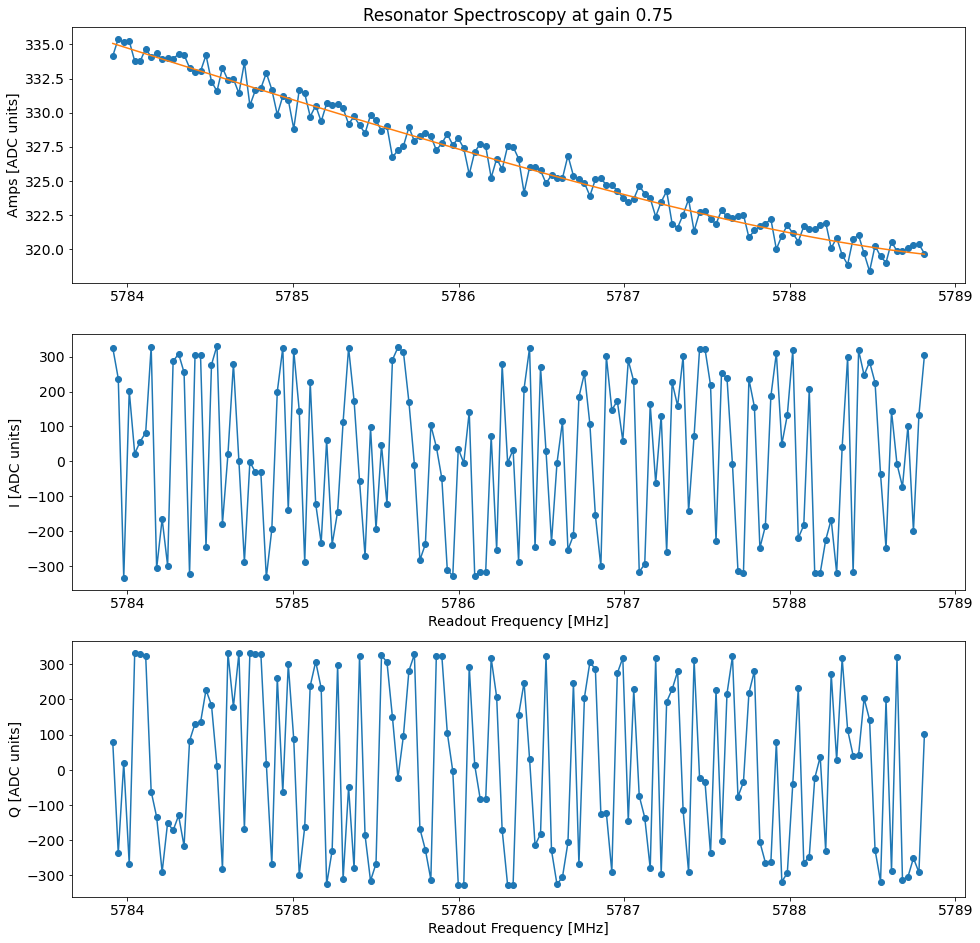

[{'Res freq': 7688.874258045896, 'Res kappa': 0.9756441096550745, 'Qubit freq': 4823.861508259508, 'Pi pulse len': 0.03956011335259716, 'Pi pulse gain': 22779, 'T1': 97.14424019836063, 'T1 err': 4.6355555889821245, 'T2R': 8.312336278065233, 'T2R err': 0.3957274632565941, 'T2E': 17.688832442781287, 'T2E err': 0.7326171278801736, 'Qubit EF freq': 4640.557961214359, 'EF pi pulse len': 0.025, 'EF pi pulse gain': 16093}, {'Res freq': 5783.299615808103, 'Res kappa': 0.30608491399697296, 'Qubit freq': 3472.403818423059, 'Pi pulse len': 0.020738980081829388, 'Pi pulse gain': 23185, 'T1': 52.567929832315315, 'T1 err': 0.6768379550408044, 'T2R': 1.8746149564710788, 'T2R err': 0.1533478261277939, 'T2E': 15.873701812556538, 'T2E err': 0.3698073838910515, 'Res chi shift (e - g)': -0.5463576158940668, 'Qubit EF freq': 603.7170605500958, 'EF pi pulse len': 0.025, 'EF pi pulse gain': 2680, 'Res chi shift (f - g)': 5.546357615894067}, {}, {}]


In [117]:
# # TESTING
# # rspecEF_chi = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspecEF_chi.data = temp_data

rspecEF_chi.analyze(fit=True)
rspecEF_chi_fit = rspecEF_chi.data['fit']
rspecEF_chi.display(fit=True)
# res_freq_f = rspecEF_chi_fit[0]
res_freq_f = rspecEF_chi.data['xpts'][np.argmin(rspecEF_chi.data['amps'])]
results_Qi.update({'Res chi shift (f - g)': yaml_cfg.device.readout.lo_sideband[qubit_i]*(res_freq_f - yaml_cfg.device.readout.frequency[qubit_i])})
# res_freq_f = 6953.5
# results_Qi.update({'Res chi shift (e - g)': res_freq_e - (5925 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.hw.soc.dacs.readout.mixer_freq + yaml_cfg.device.readout.frequency[qubit_i]))})
print(all_results)

In [118]:
if save_data: saved_files.append(rspecEF_chi.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_221007\00000_resonator_spectroscopy_chi_qubit1.h5


# Single Shot

## Single shot optimization

In [18]:
results_Qi['Res kappa'] = 0.2
# print(results_Qi['Res kappa'])

In [19]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)
shotopt.cfg = AttrDict(deepcopy(yaml_cfg))

# span_f = 2*abs(results_Qi['Res chi shift (f - g)']) # MHz
# span_f = 2*abs(results_Qi['Res chi shift (e - g)']) # MHz

# span_f = 2*abs(results_Qi['Res kappa']) # MHz
# npts_f = 15

span_f = 3*abs(results_Qi['Res kappa']) # MHz
npts_f = 20

# span_gain = 0.85
# npts_gain = 5
span_gain = 0.4
npts_gain = 4

# span_len = 8 # us
# npts_len = 2
span_len = 8 # us
npts_len = 1

shotopt.cfg.expt = dict(
    reps=15000,
    qubit=qubit_i,

    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.75*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] + 0.25*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i],
    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - span_f/2, # [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2),
    start_gain=0.1,
    step_gain=span_gain/npts_gain,
    expts_gain=npts_gain + 1,
    # start_gain=0.25,
    # step_gain=0,
    # expts_gain=1,

    start_len=8,
    step_len=0,
    expts_len=1,
    # start_len=2,
    # step_len=span_len/npts_len,
    # expts_len=npts_len + 1,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [30, 110, 105, 150], 'f_ge': [4140.530270731964, 3463.7994265949183, 4800.079246546452, 4415.18623279066], 'f_Q1_ZZ': [3458.614151840509, 0, 3462.64898922516, 3462.481397860399], 'f_ef': [3914.7570214638718, 3363.398427976613, 4610.7977211230145, 4243.1626645869355], 'f_EgGf': [2682.783, 0, 2024.7, 2407.3], 'gs': [54.38663964, 52.60236201, 41.1249601, 6.26475719, 2.73059709, 6.00700312], 'ZZs': [0.0, -5.114594559749094, -0.18282363920479838, -0.498164234703836, -5.102823962105504, 0.0, -0.9444087654687792, -1.0606959776605436, -0.18631446427480114, -0.953190326496042, 0.0, -0.4841473294491152, -0.5065394094099247, -1.0909347449496636, -0.40800300690079894, 0.0], 'pulses': {'pi_ge': {'gain': [22882, 22776, 8131, 5854], 'sigma': [0.03157, 0.04, 0.07, 0.07042806287299651], 'type': 'gauss'}, 'pi_ef': {'gain': [13782, 21716, 23173, 22120], 'sigma': [0.02117, 0.015, 0.015, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [24516, 0, 21704, 22104], 'sigma': [0.01692, 

  0%|          | 0/20 [00:00<?, ?it/s]

freq: 88.10600000000001, gain: 0.1, len: 8
	fid ge [%]: 2.2667422247408244
freq: 88.10600000000001, gain: 0.2, len: 8
	fid ge [%]: 5.1801726724224135
freq: 88.10600000000001, gain: 0.30000000000000004, len: 8
	fid ge [%]: 8.427228481898794
freq: 88.10600000000001, gain: 0.4, len: 8
	fid ge [%]: 9.167583425009168
freq: 88.10600000000001, gain: 0.5, len: 8
	fid ge [%]: 11.573719123970799
freq: 88.13600000000001, gain: 0.1, len: 8
	fid ge [%]: 2.753425114170472
freq: 88.13600000000001, gain: 0.2, len: 8
	fid ge [%]: 5.726857561918731
freq: 88.13600000000001, gain: 0.30000000000000004, len: 8
	fid ge [%]: 7.793593119770659
freq: 88.13600000000001, gain: 0.4, len: 8
	fid ge [%]: 9.306976899229975
freq: 88.13600000000001, gain: 0.5, len: 8
	fid ge [%]: 12.22707423580786
freq: 88.16600000000001, gain: 0.1, len: 8
	fid ge [%]: 3.7067902263408783
freq: 88.16600000000001, gain: 0.2, len: 8
	fid ge [%]: 6.606886896229875
freq: 88.16600000000001, gain: 0.30000000000000004, len: 8
	fid ge [%]: 8.30

(8, 4, 0)
[88.106 88.136 88.166 88.196 88.226 88.256 88.286 88.316 88.346 88.376
 88.406 88.436 88.466 88.496 88.526 88.556 88.586 88.616 88.646 88.676]
[0.1 0.2 0.3 0.4 0.5]
[8]
Max fidelity 37.79585305687046 %
Set params: 
 angle (deg) -133.54515614712392 
 threshold 1517.7894759440694 
 freq [Mhz] 88.346 
 gain [dac units] 0.5 
 readout length [us] 8


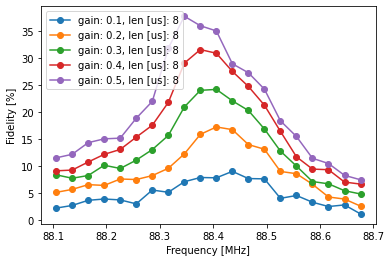

[[[0.02266742]
  [0.05180173]
  [0.08427228]
  [0.09167583]
  [0.11573719]]

 [[0.02753425]
  [0.05726858]
  [0.07793593]
  [0.09306977]
  [0.12227074]]

 [[0.0370679 ]
  [0.06606887]
  [0.08300277]
  [0.1080108 ]
  [0.14387146]]

 [[0.0394693 ]
  [0.06466882]
  [0.1020034 ]
  [0.12220407]
  [0.1508717 ]]

 [[0.03780126]
  [0.07653588]
  [0.0960032 ]
  [0.13127104]
  [0.15220507]]

 [[0.03046768]
  [0.07554089]
  [0.11147038]
  [0.15407694]
  [0.18907297]]

 [[0.05606854]
  [0.08280276]
  [0.13100437]
  [0.17607841]
  [0.22027401]]

 [[0.0519368 ]
  [0.09633654]
  [0.15713857]
  [0.21834061]
  [0.3184879 ]]

 [[0.07146905]
  [0.12293743]
  [0.20987366]
  [0.29107637]
  [0.37795853]]

 [[0.07927195]
  [0.15914394]
  [0.24074136]
  [0.31621054]
  [0.36035736]]

 [[0.07873596]
  [0.1729391 ]
  [0.24247475]
  [0.30942063]
  [0.35074502]]

 [[0.09066969]
  [0.16793893]
  [0.22127404]
  [0.27574252]
  [0.289943  ]]

 [[0.07733591]
  [0.14027134]
  [0.20341356]
  [0.2479416 ]
  [0.27327578]]


In [24]:
imax = shotopt.analyze()
shotopt.display()
print(shotopt.data['fid'])

freq_opt = shotopt.data['fpts'][imax[0]]
gain_opt = shotopt.data['gainpts'][imax[1]]
len_opt = shotopt.data['lenpts'][imax[2]]

In [306]:
if save_data: saved_files.append(shotopt.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00000_single_shot_opt_qubit0.h5


next qubit

In [89]:
qubit_i = 0
results_Qi = all_results[qubit_i]
results_Qi['Res kappa'] = 0.2
# print(results_Qi['Res kappa'])

In [308]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)
shotopt.cfg = AttrDict(deepcopy(yaml_cfg))

# span_f = 2*abs(results_Qi['Res chi shift (f - g)']) # MHz
# span_f = 2*abs(results_Qi['Res chi shift (e - g)']) # MHz

# span_f = 2*abs(results_Qi['Res kappa']) # MHz
# npts_f = 15

span_f = 3*abs(results_Qi['Res kappa']) # MHz
npts_f = 20

# span_gain = 0.85
# npts_gain = 5
span_gain = 0.3
npts_gain = 2

span_len = 8 # us
npts_len = 1

shotopt.cfg.expt = dict(
    reps=20000,
    qubit=qubit_i,

    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.75*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] + 0.25*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i],
    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - span_f/2, # [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2),
    start_gain=0.65,
    # start_gain=0.10,
    step_gain=span_gain/npts_gain,
    expts_gain=npts_gain + 1,

    start_len=8,
    # step_len=span_len/npts_len,
    # expts_len=npts_len + 1,
    step_len=0
    expts_len=1,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [25.0, 96, 37, 58], 'f_ge': [140.53780501105496, 3463.808810074577, 801.6560698688288, 415.4550753130457], 'f_Q1_ZZ': [3459.6786038062905, 0, 3463.6713203864697, 3463.502866097378], 'f_ef': [-85.23280567900892, 3363.373743527249, 621.9460573302758, 243.19506598901376], 'f_EgGf': [2678.75, 0, 2016.3, 2395.2], 'ZZs': [0.0, -4.7126775455997745, -0.10534620937775685, -0.28344964409794215, -4.236078028296106, 0.0, -0.16869289545775246, -0.2784781391173965, 0.5146242128746508, -0.12676679271078228, 0.0, -0.06125637291711428, 3.0556426555347116, 2.6356995614617063, 3.312733462014023, 0.0], 'pulses': {'pi_ge': {'gain': [22171, 24842, 20682, 24647], 'sigma': [0.04075108068027949, 0.018, 0.047, 0.025], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [23923, 22558, 21770, 21903], 'sigma': [0.03626867745453954, 0.015, 0.018, 0.0166], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [21755, 0, 22230, 22495], 'sigma': [0.017798133875785653, 0, 0.01792220834421204, 

  0%|          | 0/20 [00:00<?, ?it/s]

freq: 88.10600000000001, gain: 0.65, len: 2.0
	fid ge [%]: 11.56028900722518
freq: 88.10600000000001, gain: 0.65, len: 6.0
	fid ge [%]: 16.100402510062754
freq: 88.10600000000001, gain: 0.65, len: 10.0
	fid ge [%]: 18.745468636715916
freq: 88.10600000000001, gain: 0.8, len: 2.0
	fid ge [%]: 13.435335883397084
freq: 88.10600000000001, gain: 0.8, len: 6.0
	fid ge [%]: 16.66041651041276
freq: 88.10600000000001, gain: 0.8, len: 10.0
	fid ge [%]: 21.835545888647214
freq: 88.10600000000001, gain: 0.95, len: 2.0
	fid ge [%]: 15.730393259831496
freq: 88.10600000000001, gain: 0.95, len: 6.0
	fid ge [%]: 20.906567992599445
freq: 88.10600000000001, gain: 0.95, len: 10.0
	fid ge [%]: 25.175629390734766
freq: 88.13600000000001, gain: 0.65, len: 2.0
	fid ge [%]: 11.135556777838893
freq: 88.13600000000001, gain: 0.65, len: 6.0
	fid ge [%]: 13.560678033901697
freq: 88.13600000000001, gain: 0.65, len: 10.0
	fid ge [%]: 17.20043001075027
freq: 88.13600000000001, gain: 0.8, len: 2.0
	fid ge [%]: 12.66031

(5, 2, 2)
[88.106 88.136 88.166 88.196 88.226 88.256 88.286 88.316 88.346 88.376
 88.406 88.436 88.466 88.496 88.526 88.556 88.586 88.616 88.646 88.676]
[0.65 0.8  0.95]
[ 2.  6. 10.]
Max fidelity 39.22098052451311 %
Set params: 
 angle (deg) 63.21344812253799 
 threshold 1684.1831138018324 
 freq [Mhz] 88.25600000000001 
 gain [dac units] 0.95 
 readout length [us] 10.0


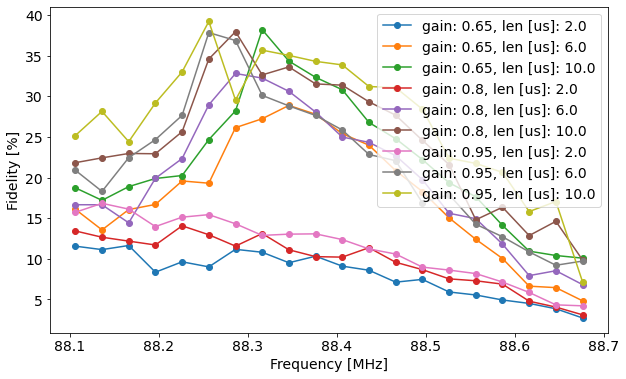

[[[0.11560289 0.16100403 0.18745469]
  [0.13435336 0.16660417 0.21835546]
  [0.15730393 0.20906568 0.25175629]]

 [[0.11135557 0.13560678 0.1720043 ]
  [0.12660317 0.16655416 0.22430561]
  [0.16835421 0.18300915 0.28151408]]

 [[0.11641164 0.16065402 0.18890472]
  [0.12180305 0.14435361 0.22970574]
  [0.16120403 0.22450561 0.24425611]]

 [[0.08355209 0.16695417 0.19890497]
  [0.11705585 0.19915498 0.22935573]
  [0.13970699 0.24675617 0.2918573 ]]

 [[0.09635241 0.19585979 0.20255506]
  [0.14065703 0.22345559 0.25651924]
  [0.15130378 0.27660692 0.33011651]]

 [[0.09010225 0.19310483 0.24675617]
  [0.12965648 0.28956448 0.34595865]
  [0.15440386 0.37850946 0.39220981]]

 [[0.11170279 0.26150654 0.28215705]
  [0.11565289 0.32816641 0.37963796]
  [0.14315358 0.36875922 0.29545739]]

 [[0.10810541 0.27245681 0.38205955]
  [0.13115328 0.32250806 0.32640816]
  [0.12885322 0.30120753 0.35690892]]

 [[0.09520238 0.28886444 0.34342576]
  [0.11115278 0.30620766 0.33625841]
  [0.13040326 0.288257

In [309]:
imax = shotopt.analyze()
shotopt.display()
print(shotopt.data['fid'])

freq_opt = shotopt.data['fpts'][imax[0]]
gain_opt = shotopt.data['gainpts'][imax[1]]
len_opt = shotopt.data['lenpts'][imax[2]]

In [310]:
if save_data: saved_files.append(shotopt.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00000_single_shot_opt_qubit3.h5


next qubit

In [311]:
qubit_i = 1
results_Qi = all_results[qubit_i]
results_Qi['Res kappa'] = 0.2
# print(results_Qi['Res kappa'])

In [312]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)
shotopt.cfg = AttrDict(deepcopy(yaml_cfg))

# span_f = 2*abs(results_Qi['Res chi shift (f - g)']) # MHz
# span_f = 2*abs(results_Qi['Res chi shift (e - g)']) # MHz

# span_f = 2*abs(results_Qi['Res kappa']) # MHz
# npts_f = 15

span_f = 3*abs(results_Qi['Res kappa']) # MHz
npts_f = 20

# span_gain = 0.85
# npts_gain = 5
span_gain = 0.3
npts_gain = 2

span_len = 8 # us
npts_len = 2

shotopt.cfg.expt = dict(
    reps=20000,
    qubit=qubit_i,

    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.75*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] + 0.25*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i],
    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - span_f/2, # [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2),
    start_gain=0.65,
    # start_gain=0.10,
    step_gain=span_gain/npts_gain,
    expts_gain=npts_gain + 1,

    start_len=2,
    step_len=span_len/npts_len,
    expts_len=npts_len + 1,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [25.0, 96, 37, 58], 'f_ge': [140.53780501105496, 3463.808810074577, 801.6560698688288, 415.4550753130457], 'f_Q1_ZZ': [3459.6786038062905, 0, 3463.6713203864697, 3463.502866097378], 'f_ef': [-85.23280567900892, 3363.373743527249, 621.9460573302758, 243.19506598901376], 'f_EgGf': [2678.75, 0, 2016.3, 2395.2], 'ZZs': [0.0, -4.7126775455997745, -0.10534620937775685, -0.28344964409794215, -4.236078028296106, 0.0, -0.16869289545775246, -0.2784781391173965, 0.5146242128746508, -0.12676679271078228, 0.0, -0.06125637291711428, 3.0556426555347116, 2.6356995614617063, 3.312733462014023, 0.0], 'pulses': {'pi_ge': {'gain': [22171, 24842, 20682, 24647], 'sigma': [0.04075108068027949, 0.018, 0.047, 0.025], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [23923, 22558, 21770, 21903], 'sigma': [0.03626867745453954, 0.015, 0.018, 0.0166], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [21755, 0, 22230, 22495], 'sigma': [0.017798133875785653, 0, 0.01792220834421204, 

  0%|          | 0/20 [00:00<?, ?it/s]

freq: -813.75, gain: 0.65, len: 2.0
	fid ge [%]: 14.340358508962725
freq: -813.75, gain: 0.65, len: 6.0
	fid ge [%]: 23.005575139378482
freq: -813.75, gain: 0.65, len: 10.0
	fid ge [%]: 28.890722268056702
freq: -813.75, gain: 0.8, len: 2.0
	fid ge [%]: 16.430410760269005
freq: -813.75, gain: 0.8, len: 6.0
	fid ge [%]: 26.580664516612917
freq: -813.75, gain: 0.8, len: 10.0
	fid ge [%]: 33.311665583279165
freq: -813.75, gain: 0.95, len: 2.0
	fid ge [%]: 17.975449386234658
freq: -813.75, gain: 0.95, len: 6.0
	fid ge [%]: 29.321466073303665
freq: -813.75, gain: 0.95, len: 10.0
	fid ge [%]: 37.68188409420471
freq: -813.72, gain: 0.65, len: 2.0
	fid ge [%]: 15.325383134578363
freq: -813.72, gain: 0.65, len: 6.0
	fid ge [%]: 25.906295314765735
freq: -813.72, gain: 0.65, len: 10.0
	fid ge [%]: 33.45083627090678
freq: -813.72, gain: 0.8, len: 2.0
	fid ge [%]: 15.955398884972125
freq: -813.72, gain: 0.8, len: 6.0
	fid ge [%]: 30.445761144028598
freq: -813.72, gain: 0.8, len: 10.0
	fid ge [%]: 37

(12, 2, 2)
[-813.75 -813.72 -813.69 -813.66 -813.63 -813.6  -813.57 -813.54 -813.51
 -813.48 -813.45 -813.42 -813.39 -813.36 -813.33 -813.3  -813.27 -813.24
 -813.21 -813.18]
[0.65 0.8  0.95]
[ 2.  6. 10.]
Max fidelity 72.19860993049653 %
Set params: 
 angle (deg) 59.10145895511285 
 threshold 144.57556226355138 
 freq [Mhz] -813.39 
 gain [dac units] 0.95 
 readout length [us] 10.0


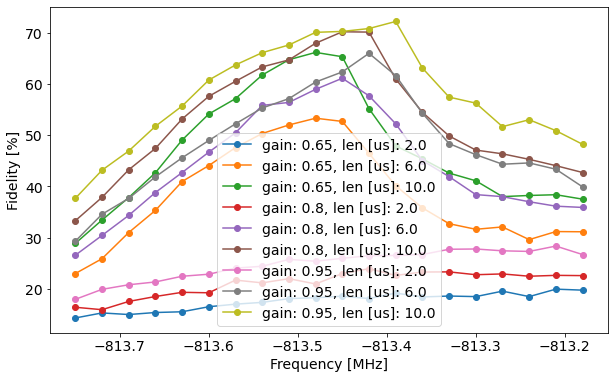

[[[0.14340359 0.23005575 0.28890722]
  [0.16430411 0.26580665 0.33311666]
  [0.17975449 0.29321466 0.37681884]]

 [[0.15325383 0.25906295 0.33450836]
  [0.15955399 0.30445761 0.37875947]
  [0.19925498 0.34580865 0.43176079]]

 [[0.15011126 0.31010775 0.37835946]
  [0.17565439 0.34355859 0.43256081]
  [0.20820521 0.37675942 0.46921173]]

 [[0.15405385 0.35330883 0.42676067]
  [0.18530927 0.38821941 0.47428557]
  [0.21370534 0.41877094 0.51746294]]

 [[0.15550778 0.40966024 0.49059906]
  [0.19345484 0.42721068 0.53166329]
  [0.22480562 0.4559842  0.55696392]]

 [[0.16535413 0.44081102 0.54137707]
  [0.19255481 0.46696167 0.5759144 ]
  [0.22880572 0.48976224 0.60766519]]

 [[0.17036278 0.4759119  0.57137857]
  [0.21730543 0.50476262 0.60521513]
  [0.24071204 0.52222611 0.63713186]]

 [[0.17385435 0.50336258 0.61744631]
  [0.2119053  0.55817791 0.63331583]
  [0.24430611 0.55311383 0.66111653]]

 [[0.18120453 0.520013   0.64733237]
  [0.2201055  0.5640282  0.64696617]
  [0.25770644 0.571414

In [313]:
imax = shotopt.analyze()
shotopt.display()
print(shotopt.data['fid'])

freq_opt = shotopt.data['fpts'][imax[0]]
gain_opt = shotopt.data['gainpts'][imax[1]]
len_opt = shotopt.data['lenpts'][imax[2]]

In [314]:
if save_data: saved_files.append(shotopt.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_230217\00000_single_shot_opt_qubit1.h5


## Best readout parameters

In [18]:
shot = meas.HistogramExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_qubit{qubit_i}",
    config_file=config_path,
)
shot.cfg = AttrDict(deepcopy(yaml_cfg))

shot.cfg.expt = dict(
    reps=30000,
    check_f=False,
    qubit=qubit_i,
)

# shot.cfg.device.readout.frequency=freq_opt
# shot.cfg.device.readout.gain=gain_opt
# shot.cfg.device.readout.readout_length = len_opt # [us]

# shot.cfg.device.readout.frequency = 819.538
# shot.cfg.device.readout.gain = 0.65
# shot.cfg.device.readout.readout_length = 2

# shot.cfg.device.readout.frequency=-807.4996158081035
# shot.cfg.device.readout.gain=0.95
# shot.cfg.device.readout.readout_length = 7 # [us]
# shot.cfg.device.readout.relax_delay = 70 # Wait time between experiments [us]
print(shot.cfg)

shot.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [25, 96, 37, 106], 'f_ge': [140.53780501105496, 3463.808810074577, 801.6560698688288, 415.4550753130457], 'f_Q1_ZZ': [3459.6644587925857, 0, 3462.62537600933, 3462.3295497147064], 'f_ef': [-85.23280567900892, 3363.373743527249, 621.9460573302758, 243.19506598901376], 'f_EgGf': [2682.75, 0, 2019.4, 2404.9], 'gs': [56.41030563, 74.31933724, 50.37948286, 19.70297012, 5.79175295, 10.44168119], 'ZZs': [0.0, -5.611248883296696, -0.9077369989172155, -1.2532967772105224, -4.73985497354488, 0.0, -1.4022731445775207, -1.2870946887073842, -1.305047898765224, -2.171251188191718, 0.0, -1.670317069756834, -1.2216609320071825, -1.8378619821536404, -0.839652822565597, 0.0], 'pulses': {'pi_ge': {'gain': [22171, 24842, 20682, 27054], 'sigma': [0.041, 0.018, 0.047, 0.022], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [23923, 22558, 21770, 24296], 'sigma': [0.036, 0.015, 0.018, 0.019], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [22200, 0, 22259, 22431], 'sigma':

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

Unrotated:
Ig 1814.5016266775112 +/- 41.32636356428551 	 Qg 984.6285075233834 +/- 41.85823982390795 	 Amp g 2064.439258259506
Ie 1852.0052867019112 +/- 43.11732808216455 	 Qe 997.5071167141115 +/- 41.6257113385217 	 Amp e 2103.5550931380735
Rotated:
Ig 2035.9661104591034 +/- 41.32636356428551 	 Qg 342.0658466774886 +/- 41.85823982390795 	 Amp g 2064.5016460156085
Ie 2075.3915775204414 +/- 43.11732808216455 	 Qe 342.28948152996946 +/- 41.6257113385217 	 Amp e 2103.4286983895704


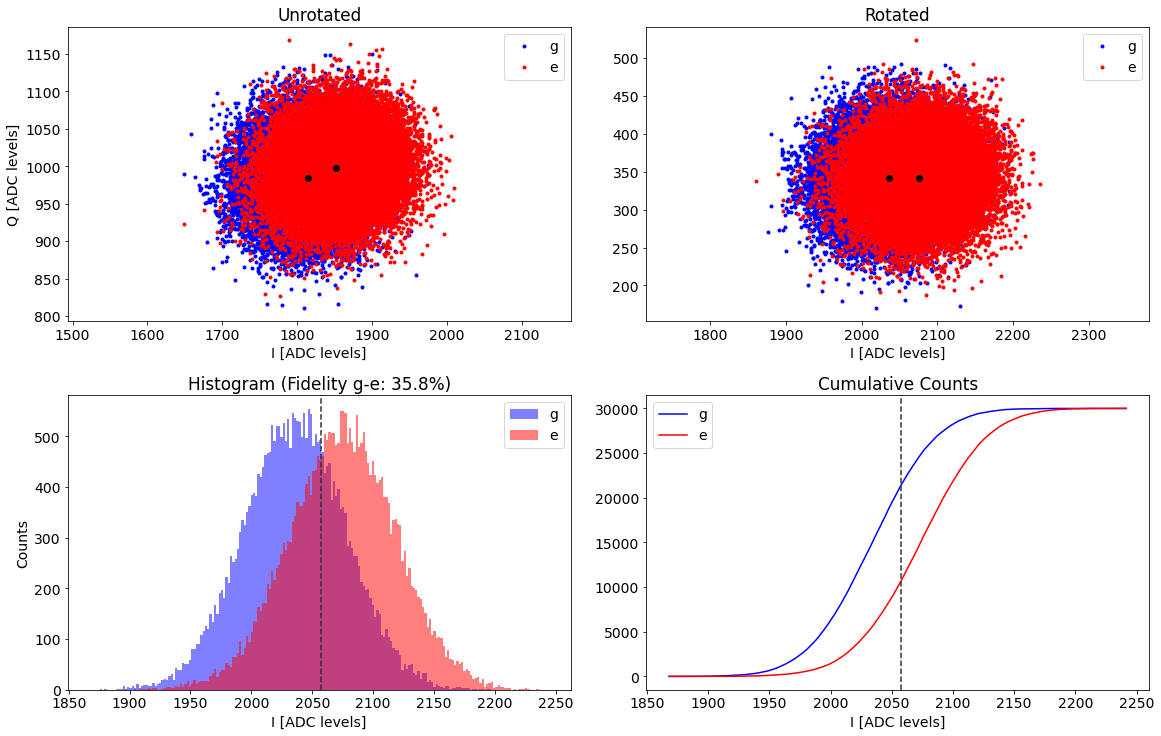

ge fidelity (%): 35.75392923215387
rotation angle (deg): -18.952269757031043
threshold ge: 2057.5560829947754


In [19]:
# # TESTING
# shot = meas.HistogramExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00001_single_shot_qubit0.h5')
# data = shot.analyze(data=temp_data)
# shot.display(data=data)

shot.analyze(verbose=False)
shot.display(verbose=True)

In [151]:
if save_data: saved_files.append(shot.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_221007\00000_single_shot_qubit1.h5


# Results

In [302]:
print(yaml_cfg)
for Qi, results in enumerate(all_results):
    print(f'Qubit {Qi}')
    for key, value in results.items():
        print(f'\t{key}: {value}')
    print()

for saved_file in saved_files:
    print(saved_file)

{'device': {'qubit': {'T1': [25.0, 96, 37, 58], 'f_ge': [140.53780501105496, 3463.808810074577, 801.6560698688288, 415.4550753130457], 'f_Q1_ZZ': [3459.6786038062905, 0, 3463.6713203864697, 3463.502866097378], 'f_ef': [-85.23280567900892, 3363.373743527249, 621.9460573302758, 243.19506598901376], 'f_EgGf': [2678.75, 0, 2016.3, 2395.2], 'ZZs': [0.0, -4.7126775455997745, -0.10534620937775685, -0.28344964409794215, -4.236078028296106, 0.0, -0.16869289545775246, -0.2784781391173965, 0.5146242128746508, -0.12676679271078228, 0.0, -0.06125637291711428, 3.0556426555347116, 2.6356995614617063, 3.312733462014023, 0.0], 'pulses': {'pi_ge': {'gain': [22171, 24842, 20682, 24647], 'sigma': [0.04075108068027949, 0.018, 0.047, 0.025], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [23923, 22558, 21770, 21903], 'sigma': [0.03626867745453954, 0.015, 0.018, 0.0166], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [21755, 0, 22230, 22495], 'sigma': [0.017798133875785653, 0, 0.01792220834421204, 